<a href="https://colab.research.google.com/github/jungsunyoo/CSSG_LCM/blob/main/CSCG_LCM_Jungsun.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from __future__ import print_function
from builtins import range
import numpy as np
import numba as nb
from tqdm import trange
import sys
import networkx as nx  # Import the networkx library
# from numba import jit
# import numpy as np
import matplotlib.pyplot as plt
import pdb

In [ ]:
# from __future__ import print_function
# from builtins import range
# import numpy as np
# import numba as nb
# from tqdm import trange
# import sys
# import networkx as nx  # Import the networkx library
# from numba import jit

def validate_seq(x, a, n_clones=None):
    """Validate an input sequence of observations x and actions a"""
    assert len(x) == len(a) > 0
    assert len(x.shape) == len(a.shape) == 1, "Flatten your array first"
    assert x.dtype == a.dtype == np.int64
    assert 0 <= x.min(), "Number of emissions inconsistent with training sequence"
    if n_clones is not None:
        assert len(n_clones.shape) == 1, "Flatten your array first"
        assert n_clones.dtype == np.int64
        assert all(
            [c > 0 for c in n_clones]
        ), "You can't provide zero clones for any emission"
        n_emissions = n_clones.shape[0]
        assert (
            x.max() < n_emissions
        ), "Number of emissions inconsistent with training sequence"


def datagen_structured_obs_room(
    room,
    start_r=None,
    start_c=None,
    no_left=[],
    no_right=[],
    no_up=[],
    no_down=[],
    length=10000,
    seed=42,
):
    """room is a 2d numpy array. inaccessible locations are marked by -1.
    start_r, start_c: starting locations

    In addition, there are invisible obstructions in the room
    which disallows certain actions from certain states.

    no_left:
    no_right:
    no_up:
    no_down:

    Each of the above are list of states from which the corresponding action is not allowed.

    """
    np.random.seed(seed)
    H, W = room.shape
    if start_r is None or start_c is None:
        start_r, start_c = np.random.randint(H), np.random.randint(W)

    actions = np.zeros(length, int)
    x = np.zeros(length, int)  # observations
    rc = np.zeros((length, 2), int)  # actual r&c

    r, c = start_r, start_c
    x[0] = room[r, c]
    rc[0] = r, c

    count = 0
    while count < length - 1:

        act_list = [0, 1, 2, 3]  # 0: left, 1: right, 2: up, 3: down
        if (r, c) in no_left:
            act_list.remove(0)
        if (r, c) in no_right:
            act_list.remove(1)
        if (r, c) in no_up:
            act_list.remove(2)
        if (r, c) in no_down:
            act_list.remove(3)

        a = np.random.choice(act_list)

        # Check for actions taking out of the matrix boundary.
        prev_r = r
        prev_c = c
        if a == 0 and 0 < c:
            c -= 1
        elif a == 1 and c < W - 1:
            c += 1
        elif a == 2 and 0 < r:
            r -= 1
        elif a == 3 and r < H - 1:
            r += 1

        # Check whether action is taking to inaccessible states.
        temp_x = room[r, c]
        if temp_x == -1:
            r = prev_r
            c = prev_c
            pass

        actions[count] = a
        x[count + 1] = room[r, c]
        rc[count + 1] = r, c
        count += 1

    return actions, x, rc

# @nb.njit
class TableContainer:
    def __init__(self):
        self.groups_of_tables = {}
        self.table_totals = {}  # Keep track of totals for each table separately
        self.total_observations = 0  # Keep track of total observations across all tables

    def add_clone(self, group_id, table_id):
        """Add exactly one clone to a specified table, creating the table or group if necessary."""
        # Automatically create the group and table if they don't exist
        if group_id not in self.groups_of_tables:
            self.groups_of_tables[group_id] = {}
        if table_id not in self.groups_of_tables[group_id]:
            self.groups_of_tables[group_id][table_id] = 0  # Initialize clones count for the table

        # Add one clone to the table count and update total observations
        self.groups_of_tables[group_id][table_id] += 1
        self.table_totals[(group_id, table_id)] = self.groups_of_tables[group_id][table_id]  # Update table total
        self.total_observations += 1

    def get_total_observations(self):
        """Return the total number of observations."""
        return self.total_observations

    def get_group_total(self, group_id):
        """Return the total number of clones in all tables within a specific group."""
        return sum(self.groups_of_tables.get(group_id, {}).values())

    def get_table_total(self, group_id, table_id):
        """Return the total number of clones for a specific table."""
        return self.groups_of_tables.get(group_id, {}).get(table_id, 0)

    def count_tables_in_group(self, group_id):
        """Returns the number of tables within the specified group."""
        if group_id in self.groups_of_tables:
            return len(self.groups_of_tables[group_id])
        else:
            print(f"Group {group_id} does not exist.")
            return 0

def CRP(container, curr_observation, alpha=1.0):
    """
    Simulates the Chinese Restaurant Process.

    Parameters:
    - history: int, the total number of customers to simulate.
    - alpha: float, the concentration parameter.

    Returns:
    - A list where the i-th element represents the table number of the i-th customer.
    """
    # if customers <= 0:
    #     return []

    # # The table assignments for each customer
    # assignments = [1]  # The first customer always chooses the first table
    # table_counts = {1: 1}  # Table 1 has one customer

    # for n in range(1, customers):  # Start with the second customer
      # Compute the probabilities for each table and a new table
    # table_counts = all_table_counts[curr_observation]

    n = container.get_group_total(curr_observation)


    if curr_observation not in container.groups_of_tables:
      container.add_clone(curr_observation,1)
      table_choice = 1
      assignments = 1
      probs = 1
    else:
      probs = [clone_count / (n + alpha) for table_id, clone_count in container.groups_of_tables[curr_observation].items()] + [alpha / (n + alpha)]
      # probs = [clone_count / (n + alpha) for table_id, clone_count in container.groups_of_tables] + [alpha / (n + alpha)]
        # for table_id, clone_count in container.groups_of_tables:



    # probs = [count / (n + alpha) for count in table_counts.values()] + [alpha / (n + alpha)]
    # Choose a table based on the probabilities
      table_choice = np.random.choice(len(probs), p=probs)

    # update clone --> existing or new, same
      container.add_clone(curr_observation,table_choice+1)
      assignments = table_choice+1


    # if table_choice == len(table_counts):
        # Create a new table
        # container.add_clone(curr_observation,table_choice+1)
        # table_counts[curr_observation][table_choice + 1] = 1
        # assignments = table_choice + 1
    # else:
        # Join an existing table
        # container.add_clone(curr_observation, table_choice)
        # table = list(table_counts.keys())[table_choice]
        # table_counts[curr_observation][table] += 1
        # assignments.append(table)
        # assignments = table

    return assignments, probs
# # Example usage
# container = TableContainer()

# # Adding clones to new or existing groups and tables
# container.add_clone(1, 1)  # Adds one clone to Group 1, Table 1
# container.add_clone(1, 1)  # Adds another clone to Group 1, Table 1
# container.add_clone(1, 2)  # Adds one clone to Group 1, Table 2
# container.add_clone(2, 1)  # Adds one clone to Group 2, Table 1

# print("Group 1, Table 1 Total Clones:", container.get_table_total(1, 1))
# print("Group 1 Total Clones:", container.get_group_total(1))
# print("Group 2 Total Clones:", container.get_group_total(2))
# print("Total Observations:", container.get_total_observations())




# @nb.njit


# Example usage
# customers = 100  # Number of customers
# alpha = 1.0  # Concentration parameter
# assignments, table_counts = CRP(customers, alpha)
# print("Table assignments:", assignments)
# print("Number of tables: ", np.unique(assignments))
# plt.hist(assignments)
# plt.show()


class CHMM_LCM(object):
    def __init__(self, x, a, container, n_clones=1, pseudocount=0.0, alpha=1.0, dtype=np.float32, seed=42):
        """Construct a CHMM objct. n_clones is an array where n_clones[i] is the
        number of clones assigned to observation i. x and a are the observation sequences
        and action sequences, respectively."""
        np.random.seed(seed)
        n_states = len(np.unique(x))# self.n_clones.sum() # this should be changed too; for now, just define them as observations
        n_actions = a.max() + 1
        self.n_clones = n_states #n_clones
        # validate_seq(x, a, self.n_clones)
        assert pseudocount >= 0.0, "The pseudocount should be positive"
        # print("Average number of clones:", n_clones.mean())
        self.pseudocount = pseudocount
        self.dtype = dtype

        # self.C = np.random.rand(n_actions, n_states, n_states).astype(dtype) # this should be changed; actually, n_actions, n_states should be modified too
        self.C = np.random.rand(n_actions, n_states, n_states).astype(dtype) # this should be changed; actually, n_actions, n_states should be modified too

        self.Pi_x = np.ones(n_states) / n_states
        self.Pi_a = np.ones(n_actions) / n_actions
        self.update_T()
        self.container = container
        self.alpha = alpha
        # self.container = TableContainer() # initialize CRP
        # self.all_table_counts = {}
        # for i in range(1, len(n_clones) + 1):
        #     self.all_table_counts[i] = {1: 1}  # Each table initialized with {1: 1}



    def update_T(self):
        """Update the transition matrix given the accumulated counts matrix."""
        self.T = self.C + self.pseudocount
        norm = self.T.sum(2, keepdims=True)
        norm[norm == 0] = 1
        self.T /= norm


    # def update_T(self):
    #     self.T = self.C + self.pseudocount
    #     norm = self.T.sum(2, keepdims=True)  # old model (conditional on actions)
    #     norm[norm == 0] = 1
    #     self.T /= norm
    #     norm = self.T.sum((0, 2), keepdims=True)  # new model (generates actions too)
    #     norm[norm == 0] = 1
    #     self.T /= norm

    def update_E(self, CE):
        """Update the emission matrix."""
        E = CE + self.pseudocount
        norm = E.sum(1, keepdims=True)
        norm[norm == 0] = 1
        E /= norm
        return E

    def bps(self, x, a):
        """Compute the log likelihood (log base 2) of a sequence of observations and actions."""
        validate_seq(x, a, self.n_clones)
        log2_lik = forward(self.T.transpose(0, 2, 1), self.Pi_x, self.n_clones, x, a)[0]
        return -log2_lik

    def bpsE(self, E, x, a):
        """Compute the log likelihood using an alternate emission matrix."""
        validate_seq(x, a, self.n_clones)
        log2_lik = forwardE(
            self.T.transpose(0, 2, 1), E, self.Pi_x, self.n_clones, x, a
        )
        return -log2_lik

    def bpsV(self, x, a):
        validate_seq(x, a, self.n_clones)
        log2_lik = forward_mp(
            self.T.transpose(0, 2, 1), self.Pi_x, self.n_clones, x, a
        )[0]
        return -log2_lik

    def decode(self, x, a):
        """Compute the MAP assignment of latent variables using max-product message passing."""
        log2_lik, mess_fwd = forward_mp(
            self.T.transpose(0, 2, 1),
            self.Pi_x,
            self.n_clones,
            x,
            a,
            store_messages=True,
        )
        states, ginis = backtrace(self.T, self.n_clones, x, a, mess_fwd)
        # print(mess_fwd)
        return -log2_lik, states, ginis

    def decodeE(self, E, x, a):
        """Compute the MAP assignment of latent variables using max-product message passing
        with an alternative emission matrix."""
        log2_lik, mess_fwd = forwardE_mp(
            self.T.transpose(0, 2, 1),
            E,
            self.Pi_x,
            self.n_clones,
            x,
            a,
            store_messages=True,
        )
        states = backtraceE(self.T, E, self.n_clones, x, a, mess_fwd)
        return -log2_lik, states

    def learn_em_T(self, x, a, n_iter=100, term_early=True):
        """Run EM training, keeping E deterministic and fixed, learning T"""
        sys.stdout.flush()
        convergence = []
        pbar = trange(n_iter, position=0)
        log2_lik_old = -np.inf
        # pdb.set_trace()
        for it in pbar:
            # E
            log2_lik, mess_fwd, n_clones, T = forward(
                self.T,#.transpose(0, 2, 1),
                self.Pi_x, # this seems to be initialized just at once (no further updates)
                self.n_clones,
                x,
                a,
                self.container,
                self.alpha,
                store_messages=True,
            )
            # update self.n_clones
            # update T
            self.n_clones = n_clones
            self.T = T
            mess_bwd = backward(self.T, self.n_clones, x, a)
            updateC(self.C, self.T, self.n_clones, mess_fwd, mess_bwd, x, a)
            # M
            self.update_T()
            convergence.append(-log2_lik.mean())
            pbar.set_postfix(train_bps=convergence[-1])
            if log2_lik.mean() <= log2_lik_old:
                if term_early:
                    break
            log2_lik_old = log2_lik.mean()
            # print(log2_lik_old)
        # JY added for plotting learning curve
        plt.plot(convergence, label='Training Loss')
        plt.title('Learning Curve')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.show()
        return convergence

    def learn_viterbi_T(self, x, a, n_iter=100):
        """Run Viterbi training, keeping E deterministic and fixed, learning T"""
        sys.stdout.flush()
        convergence = []
        pbar = trange(n_iter, position=0)
        log2_lik_old = -np.inf
        for it in pbar:
            # E
            log2_lik, mess_fwd = forward_mp(
                self.T.transpose(0, 2, 1),
                self.Pi_x,
                self.n_clones,
                x,
                a,
                store_messages=True,
            )
            states,_ = backtrace(self.T, self.n_clones, x, a, mess_fwd)
            self.C[:] = 0
            for t in range(1, len(x)):
                aij, i, j = (
                    a[t - 1],
                    states[t - 1],
                    states[t],
                )  # at time t-1 -> t we go from observation i to observation j
                self.C[aij, i, j] += 1.0
            # M
            self.update_T()

            convergence.append(-log2_lik.mean())
            pbar.set_postfix(train_bps=convergence[-1])
            if log2_lik.mean() <= log2_lik_old:
                break
            log2_lik_old = log2_lik.mean()
        return convergence

    def learn_em_E(self, x, a, n_iter=100, pseudocount_extra=1e-20):
        """Run Viterbi training, keeping T fixed, learning E"""
        sys.stdout.flush()
        n_emissions, n_states = len(self.n_clones), self.n_clones.sum()
        CE = np.ones((n_states, n_emissions), self.dtype)
        E = self.update_E(CE + pseudocount_extra)
        convergence = []
        pbar = trange(n_iter, position=0)
        log2_lik_old = -np.inf
        for it in pbar:
            # E
            log2_lik, mess_fwd = forwardE(
                self.T.transpose(0, 2, 1),
                E,
                self.Pi_x,
                self.n_clones,
                x,
                a,
                store_messages=True,
            )
            mess_bwd = backwardE(self.T, E, self.n_clones, x, a)
            updateCE(CE, E, self.n_clones, mess_fwd, mess_bwd, x, a)
            # M
            E = self.update_E(CE + pseudocount_extra)
            convergence.append(-log2_lik.mean())
            pbar.set_postfix(train_bps=convergence[-1])
            if log2_lik.mean() <= log2_lik_old:
                break
            log2_lik_old = log2_lik.mean()
        return convergence, E

    def sample(self, length):
        """Sample from the CHMM."""
        assert length > 0
        state_loc = np.hstack(([0], self.n_clones)).cumsum(0)
        sample_x = np.zeros(length, dtype=np.int64)
        sample_a = np.random.choice(len(self.Pi_a), size=length, p=self.Pi_a)

        # Sample
        p_h = self.Pi_x
        for t in range(length):
            h = np.random.choice(len(p_h), p=p_h)
            sample_x[t] = np.digitize(h, state_loc) - 1
            p_h = self.T[sample_a[t], h]
        return sample_x, sample_a

    def sample_sym(self, sym, length):
        """Sample from the CHMM conditioning on an inital observation."""
        # Prepare structures
        assert length > 0
        state_loc = np.hstack(([0], self.n_clones)).cumsum(0)

        seq = [sym]

        alpha = np.ones(self.n_clones[sym])
        alpha /= alpha.sum()

        for _ in range(length):
            obs_tm1 = seq[-1]
            T_weighted = self.T.sum(0)

            long_alpha = np.dot(
                alpha, T_weighted[state_loc[obs_tm1] : state_loc[obs_tm1 + 1], :]
            )
            long_alpha /= long_alpha.sum()
            idx = np.random.choice(np.arange(self.n_clones.sum()), p=long_alpha)

            sym = np.digitize(idx, state_loc) - 1
            seq.append(sym)

            temp_alpha = long_alpha[state_loc[sym] : state_loc[sym + 1]]
            temp_alpha /= temp_alpha.sum()
            alpha = temp_alpha

        return seq

    def bridge(self, state1, state2, max_steps=100):
        Pi_x = np.zeros(self.n_clones.sum(), dtype=self.dtype)
        Pi_x[state1] = 1
        log2_lik, mess_fwd = forward_mp_all(
            self.T.transpose(0, 2, 1), Pi_x, self.Pi_a, self.n_clones, state2, max_steps
        )
        s_a = backtrace_all(self.T, self.Pi_a, self.n_clones, mess_fwd, state2)
        return s_a


def updateCE(CE, E, n_clones, mess_fwd, mess_bwd, x, a):
    timesteps = len(x)
    gamma = mess_fwd * mess_bwd
    norm = gamma.sum(1, keepdims=True)
    norm[norm == 0] = 1
    gamma /= norm
    CE[:] = 0
    for t in range(timesteps):
        CE[:, x[t]] += gamma[t]


def forwardE(T_tr, E, Pi, n_clones, x, a, store_messages=False):
    """Log-probability of a sequence, and optionally, messages"""
    assert (n_clones.sum(), len(n_clones)) == E.shape
    dtype = T_tr.dtype.type

    # forward pass
    t, log2_lik = 0, np.zeros(len(x), dtype)
    j = x[t]
    message = Pi * E[:, j]
    p_obs = message.sum()
    assert p_obs > 0
    message /= p_obs
    log2_lik[0] = np.log2(p_obs)
    if store_messages:
        mess_fwd = np.empty((len(x), E.shape[0]), dtype=dtype)
        mess_fwd[t] = message
    for t in range(1, x.shape[0]):
        aij, j = (
            a[t - 1],
            x[t],
        )  # at time t-1 -> t we go from observation i to observation j
        message = T_tr[aij].dot(message)
        message *= E[:, j]
        p_obs = message.sum()
        assert p_obs > 0
        message /= p_obs
        log2_lik[t] = np.log2(p_obs)
        if store_messages:
            mess_fwd[t] = message
    if store_messages:
        return log2_lik, mess_fwd
    else:
        return log2_lik


def backwardE(T, E, n_clones, x, a):
    """Compute backward messages."""
    assert (n_clones.sum(), len(n_clones)) == E.shape
    dtype = T.dtype.type

    # backward pass
    t = x.shape[0] - 1
    message = np.ones(E.shape[0], dtype)
    message /= message.sum()
    mess_bwd = np.empty((len(x), E.shape[0]), dtype=dtype)
    mess_bwd[t] = message
    for t in range(x.shape[0] - 2, -1, -1):
        aij, j = (
            a[t],
            x[t + 1],
        )  # at time t -> t+1 we go from observation i to observation j
        message = T[aij].dot(message * E[:, j])
        p_obs = message.sum()
        assert p_obs > 0
        message /= p_obs
        mess_bwd[t] = message
    return mess_bwd


# @nb.njit
def updateC(C, T, n_clones, mess_fwd, mess_bwd, x, a):
    state_loc = np.hstack((np.array([0], dtype=n_clones.dtype), n_clones)).cumsum()
    mess_loc = np.hstack((np.array([0], dtype=n_clones.dtype), n_clones[x])).cumsum()
    timesteps = len(x)
    C[:] = 0
    for t in range(1, timesteps):
        aij, i, j = (
            a[t - 1],
            x[t - 1],
            x[t],
        )  # at time t-1 -> t we go from observation i to observation j
        (tm1_start, tm1_stop), (t_start, t_stop) = (
            mess_loc[t - 1 : t + 1],
            mess_loc[t : t + 2],
        )
        (i_start, i_stop), (j_start, j_stop) = (
            state_loc[i : i + 2],
            state_loc[j : j + 2],
        )
        q = (
            mess_fwd[tm1_start:tm1_stop].reshape(-1, 1)
            * T[aij, i_start:i_stop, j_start:j_stop]
            * mess_bwd[t_start:t_stop].reshape(1, -1)
        )
        q /= q.sum()
        C[aij, i_start:i_stop, j_start:j_stop] += q

def post_clone_T(matrix, insert_row, insert_col, new_element=None, placeholder=None):
    # If new_element is not specified, generate a random number using np.random.rand()
    if new_element is None:
        new_element = np.random.rand()
    # Determine the size of the original matrix
    num_slices, original_rows, original_cols = matrix.shape

    # Create a new matrix with additional row and column for each slice
    new_matrix_shape = (num_slices, original_rows + 1, original_cols + 1)
    if placeholder is None:
      new_matrix = np.random.rand(*new_matrix_shape)
    else:
      new_matrix = np.full(new_matrix_shape, placeholder, dtype=object)  # Use if a specific placeholder is required
    # if placeholder is None:
    #   # Create a new matrix with additional row and column
    #   new_matrix = [[np.random.rand() for _ in range(original_cols + 1)] for __ in range(original_rows + 1)]
    # else:
    #   new_matrix = [[placeholder for _ in range(original_cols + 1)] for __ in range(original_rows + 1)]

    for slice_index in range(num_slices):
        for i in range(original_rows + 1):
            for j in range(original_cols + 1):
                if i == insert_row and j == insert_col:
                    if new_element is not None:
                        # Insert the new element if specified
                        new_matrix[slice_index, i, j] = new_element
                elif i < insert_row and j < insert_col:
                    new_matrix[slice_index, i, j] = matrix[slice_index, i, j]
                elif i <= insert_row or j <= insert_col:
                    # For elements in the new row or column, keep the random value,
                    # or insert a placeholder if it's specified and we're not in the insertion cell
                    if placeholder is not None and (i == insert_row or j == insert_col):
                        new_matrix[slice_index, i, j] = placeholder
                else:
                    # Adjust indices for copying from the original matrix
                    orig_i, orig_j = (i - 1 if i > insert_row else i), (j - 1 if j > insert_col else j)
                    new_matrix[slice_index, i, j] = matrix[slice_index, orig_i, orig_j]

    return new_matrix


def forward(T_tr, Pi, n_clones, x, a, container,alpha=1.0,store_messages=False):
  # JY changed for full bottom-up assignment of clones (i.e., no prior assumption about the number of observations)
    """Log-probability of a sequence, and optionally, messages"""

    # Assumption: no prior assumption about the observations, and assume no clones (clones will only be created after direct experience;
    # but interesting to assume transfer learning (i.e., clone creation in a similar observation will lead to creation of another similar observation?) )
    # T_tr = self.T

    # Pi: nclone * nobservations (e.g., 2 clones * 5 observations == 10 states)
    dtype = T_tr.dtype.type


    # Assume a blank state of observations:
    # create an empty list to store unique observations
    unique_obs = []
    # create an empty list to store number of clones

    # Don't initialize after 1st iteration
    # print(container.get_total_observations())
    if container.get_total_observations() == 0:
      # print('initialized')
      n_clones = np.array([], dtype=np.int64)
    mess_loc = np.array([0]) # np.array([], dtype=dtype)
    mess_fwd = np.array([0]) # np.array([], dtype=dtype)

    # forward pass
    t, log2_lik = 0, np.zeros(len(x), dtype)
    j = x[t] # this is the first observation

    # Loop through the observations and add unique elements to the list
    if j not in unique_obs:
      unique_obs.append(j)

    # This is where CRP (clone separation) happens
    # def CRP(n, table_counts, curr_observation, alpha=1.0):
    ind = unique_obs.index(j)
    prev_tables = container.count_tables_in_group(ind)
    # pdb.set_trace()
    # print(prev_tables)

    assignment, _ =  CRP(container, ind, alpha=alpha)
    post_tables = container.count_tables_in_group(ind)
    # print(post_tables)

    if prev_tables != post_tables: # a new clone has been created for this observation

      # n_clones[j-1] += 1
      # if ind >= len(n_clones): # n_clones[ind] does not exist
      n_clones = np.append(n_clones, 1)
      print('splitted')
      # n_clones = np.concatenate((n_clones, np.array([0])))  # Append an initial array
      # n_clones[ind] += int(1)
    state_loc = np.hstack((np.array([0], dtype=n_clones.dtype), n_clones)).cumsum() # redefine start # of the states (observations)
    # print(state_loc)
      # if store_messages:
      #   mess_loc = np.hstack((np.array([0], dtype=n_clones.dtype), n_clones[x])).cumsum()

    # now update clone matrix if different clone has been created

    # JY: Update Pi (initial probability) according to the clone
    n_states = n_clones.sum()
    # print(n_states)
    Pi = np.ones(n_states) / n_states
    # print(Pi)

    # j_start, j_stop = state_loc[j : j + 2]
    j_start, j_stop = state_loc[ind : ind + 2]

    message = Pi[j_start:j_stop].copy().astype(dtype)
    p_obs = message.sum()
    assert p_obs > 0
    message /= p_obs
    log2_lik[0] = np.log2(p_obs)
    if store_messages:
        # mess_loc = np.hstack(
        #     (np.array([0], dtype=n_clones.dtype), n_clones[x])
        # ).cumsum()
        # mess_fwd = np.empty(mess_loc[-1], dtype=dtype)
        # t_start, t_stop = mess_loc[t : t + 2]
        # mess_fwd[t_start:t_stop] = message

        # All of the above should be changed
        mess_loc = np.append(mess_loc, n_clones[ind])
        mess_fwd = np.empty(mess_loc[-1], dtype=dtype)
        t_start, t_stop = mess_loc[t : t + 2]
        mess_fwd[t_start:t_stop] = message

    # else:
    #     mess_fwd = None

    # T_tr should be modified too

    for t in range(1, x.shape[0]):
        aij, i, j = (
            a[t - 1],
            x[t - 1],
            x[t],
        )  # at time t-1 -> t we go from observation i to observation j

        # 1. Loop through the observations and add unique elements to the list
        if j not in unique_obs:
          unique_obs.append(j)
        old_ind = ind # previous index
        ind = unique_obs.index(j) # observation index

        # This is where CRP (clone separation) happens
        prev_tables = container.count_tables_in_group(ind)
        # print(prev_tables)
        assignment, _ =  CRP(container, ind, alpha=alpha)
        post_tables = container.count_tables_in_group(ind)
        # print(post_tables)

        if prev_tables != post_tables: # a new clone has been created for this observation
          if ind >= len(n_clones): # n_clones[ind] does not exist
            n_clones = np.append(n_clones, 1)
            # n_clones = np.concatenate((n_clones, np.array([0])))  # Append an initial array
          # n_clones[ind] += 1
          # Insert T_tr?
          # T_tr[aij,]

        state_loc = np.hstack((np.array([0], dtype=n_clones.dtype), n_clones)).cumsum() # redefine start # of the states (observations)

        (i_start, i_stop), (j_start, j_stop) = (
            # state_loc[i : i + 2],
            # state_loc[j : j + 2],
            state_loc[old_ind : old_ind + 2],
            state_loc[ind : ind + 2],
        )

        if prev_tables != post_tables: # a new clone has been created for this observation
          # Transition matrix
          # matrix = T_tr[aij,:,:]
          T_tr = post_clone_T(T_tr, state_loc[ind], state_loc[ind])




        # Now that we have a[t-1], x[t-1], x[t] (and the latent states), update the transition matrix accordingly
        # np.random.rand(n_actions, 1, 1)
        #### PICK UP LATER: TRANSITION MATRIX!!! (HOW TO DYNAMICALLY UPDATE ACCORDING TO NEW TRANSITIONS)

        # print("T_tr = {}".format(T_tr[aij, j_start:j_stop, i_start:i_stop]))
        # print("Message: {}".format(message))
        message = np.ascontiguousarray(T_tr[aij, j_start:j_stop, i_start:i_stop]).dot(
            message
        )
        p_obs = message.sum()
        assert p_obs > 0
        message /= p_obs
        log2_lik[t] = np.log2(p_obs)
        if store_messages:
            mess_loc = np.append(mess_loc, n_clones[ind])
            # print('mess_loc: {}'.format(mess_loc))
            t_start, t_stop = mess_loc[t : t + 2]
            # print('message: {}'.format(message))
            mess_fwd = np.append(mess_fwd, message)
            # mess_fwd[t_start:t_stop] = message
            # print(mess_loc, len(mess_fwd))
    return log2_lik, mess_fwd, n_clones, T_tr #, state_loc, Pi # JY added state_loc and Pi for updated clones

def backward(T, n_clones, x, a):
    """Compute backward messages."""
    state_loc = np.hstack((np.array([0], dtype=n_clones.dtype), n_clones)).cumsum()
    dtype = T.dtype.type

    # backward pass
    t = x.shape[0] - 1
    i = x[t]
    message = np.ones(n_clones[i], dtype) / n_clones[i]
    message /= message.sum()
    mess_loc = np.hstack((np.array([0], dtype=n_clones.dtype), n_clones[x])).cumsum()
    mess_bwd = np.empty(mess_loc[-1], dtype)
    t_start, t_stop = mess_loc[t : t + 2]
    mess_bwd[t_start:t_stop] = message
    for t in range(x.shape[0] - 2, -1, -1):
        aij, i, j = (
            a[t],
            x[t],
            x[t + 1],
        )  # at time t -> t+1 we go from observation i to observation j
        (i_start, i_stop), (j_start, j_stop) = (
            state_loc[i : i + 2],
            state_loc[j : j + 2],
        )
        message = np.ascontiguousarray(T[aij, i_start:i_stop, j_start:j_stop]).dot(
            message
        )
        p_obs = message.sum()
        assert p_obs > 0
        message /= p_obs
        t_start, t_stop = mess_loc[t : t + 2]
        mess_bwd[t_start:t_stop] = message
    return mess_bwd


# @nb.njit
def forward_mp(T_tr, Pi, n_clones, x, a, store_messages=False):
    """Log-probability of a sequence, and optionally, messages"""
    state_loc = np.hstack((np.array([0], dtype=n_clones.dtype), n_clones)).cumsum()
    dtype = T_tr.dtype.type

    # forward pass
    t, log2_lik = 0, np.zeros(len(x), dtype)
    j = x[t]
    j_start, j_stop = state_loc[j : j + 2]
    message = Pi[j_start:j_stop].copy().astype(dtype)
    p_obs = message.max()
    assert p_obs > 0
    message /= p_obs
    log2_lik[0] = np.log2(p_obs)
    if store_messages:
        mess_loc = np.hstack(
            (np.array([0], dtype=n_clones.dtype), n_clones[x])
        ).cumsum()
        mess_fwd = np.empty(mess_loc[-1], dtype=dtype)
        t_start, t_stop = mess_loc[t : t + 2]
        mess_fwd[t_start:t_stop] = message
    else:
        mess_fwd = None

    for t in range(1, x.shape[0]):
        aij, i, j = (
            a[t - 1],
            x[t - 1],
            x[t],
        )  # at time t-1 -> t we go from observation i to observation j
        (i_start, i_stop), (j_start, j_stop) = (
            state_loc[i : i + 2],
            state_loc[j : j + 2],
        )
        new_message = np.zeros(j_stop - j_start, dtype=dtype)
        for d in range(len(new_message)):
            new_message[d] = (T_tr[aij, j_start + d, i_start:i_stop] * message).max()
        message = new_message
        p_obs = message.max()
        assert p_obs > 0
        message /= p_obs
        log2_lik[t] = np.log2(p_obs)
        if store_messages:
            t_start, t_stop = mess_loc[t : t + 2]
            mess_fwd[t_start:t_stop] = message
    return log2_lik, mess_fwd


# @nb.njit
def rargmax(x):
    # return x.argmax()  # <- favors clustering towards smaller state numbers
    return np.random.choice((x == x.max()).nonzero()[0])


# @nb.njit
def backtrace(T, n_clones, x, a, mess_fwd):
    """Compute backward messages."""
    state_loc = np.hstack((np.array([0], dtype=n_clones.dtype), n_clones)).cumsum()
    mess_loc = np.hstack((np.array([0], dtype=n_clones.dtype), n_clones[x])).cumsum()
    code = np.zeros(x.shape[0], dtype=np.int64)

    # backward pass
    t = x.shape[0] - 1
    i = x[t]
    t_start, t_stop = mess_loc[t : t + 2]
    belief = mess_fwd[t_start:t_stop]
    code[t] = rargmax(belief)
    ginis = []
    for t in range(x.shape[0] - 2, -1, -1):
        aij, i, j = (
            a[t],
            x[t],
            x[t + 1],
        )  # at time t -> t+1 we go from observation i to observation j
        (i_start, i_stop), j_start = state_loc[i : i + 2], state_loc[j]
        t_start, t_stop = mess_loc[t : t + 2]
        belief = (
            mess_fwd[t_start:t_stop] * T[aij, i_start:i_stop, j_start + code[t + 1]]
        )
        # JY added to calculate the distribution of beliefs:
        gini = gini_coefficient(belief)

        code[t] = rargmax(belief)
        ginis.append(gini)
    states = state_loc[x] + code
    return states, ginis


def backtraceE(T, E, n_clones, x, a, mess_fwd):
    """Compute backward messages."""
    assert (n_clones.sum(), len(n_clones)) == E.shape
    states = np.zeros(x.shape[0], dtype=np.int64)

    # backward pass
    t = x.shape[0] - 1
    belief = mess_fwd[t]
    states[t] = rargmax(belief)
    for t in range(x.shape[0] - 2, -1, -1):
        aij = a[t]  # at time t -> t+1 we go from observation i to observation j
        belief = mess_fwd[t] * T[aij, :, states[t + 1]]
        states[t] = rargmax(belief)
    return states


def forwardE_mp(T_tr, E, Pi, n_clones, x, a, store_messages=False):
    """Log-probability of a sequence, and optionally, messages"""
    assert (n_clones.sum(), len(n_clones)) == E.shape
    dtype = T_tr.dtype.type

    # forward pass
    t, log2_lik = 0, np.zeros(len(x), dtype)
    j = x[t]
    message = Pi * E[:, j]
    p_obs = message.max()
    assert p_obs > 0
    message /= p_obs
    log2_lik[0] = np.log2(p_obs)
    if store_messages:
        mess_fwd = np.empty((len(x), E.shape[0]), dtype=dtype)
        mess_fwd[t] = message
    for t in range(1, x.shape[0]):
        aij, j = (
            a[t - 1],
            x[t],
        )  # at time t-1 -> t we go from observation i to observation j
        message = (T_tr[aij] * message.reshape(1, -1)).max(1)
        message *= E[:, j]
        p_obs = message.max()
        assert p_obs > 0
        message /= p_obs
        log2_lik[t] = np.log2(p_obs)
        if store_messages:
            mess_fwd[t] = message
    if store_messages:
        return log2_lik, mess_fwd
    else:
        return log2_lik


def forward_mp_all(T_tr, Pi_x, Pi_a, n_clones, target_state, max_steps):
    """Log-probability of a sequence, and optionally, messages"""
    # forward pass
    t, log2_lik = 0, []
    message = Pi_x
    p_obs = message.max()
    assert p_obs > 0
    message /= p_obs
    log2_lik.append(np.log2(p_obs))
    mess_fwd = []
    mess_fwd.append(message)
    T_tr_maxa = (T_tr * Pi_a.reshape(-1, 1, 1)).max(0)
    for t in range(1, max_steps):
        message = (T_tr_maxa * message.reshape(1, -1)).max(1)
        p_obs = message.max()
        assert p_obs > 0
        message /= p_obs
        log2_lik.append(np.log2(p_obs))
        mess_fwd.append(message)
        if message[target_state] > 0:
            break
    else:
        assert False, "Unable to find a bridging path"
    return np.array(log2_lik), np.array(mess_fwd)


def backtrace_all(T, Pi_a, n_clones, mess_fwd, target_state):
    """Compute backward messages."""
    states = np.zeros(mess_fwd.shape[0], dtype=np.int64)
    actions = np.zeros(mess_fwd.shape[0], dtype=np.int64)
    n_states = T.shape[1]
    # backward pass
    t = mess_fwd.shape[0] - 1
    actions[t], states[t] = (
        -1,
        target_state,
    )  # last actions is irrelevant, use an invalid value
    for t in range(mess_fwd.shape[0] - 2, -1, -1):
        belief = (
            mess_fwd[t].reshape(1, -1) * T[:, :, states[t + 1]] * Pi_a.reshape(-1, 1)
        )
        a_s = rargmax(belief.flatten())
        actions[t], states[t] = a_s // n_states, a_s % n_states
    return actions, states

# @nb.njit
def gini_coefficient(values):
    """
    Calculate the Gini coefficient of a numpy array.

    Parameters:
    - values: a list or numpy array of values.

    Returns:
    - The Gini coefficient as a float.
    """
    # First we sort the array because the Gini coefficient formula assumes the array is sorted
    values = np.sort(values)
    # Calculate the cumulative sum of the sorted array
    cumsum = np.cumsum(values)
    # Calculate the Gini coefficient using the alternative formula
    n = len(values)
    gini = (n + 1 - 2 * np.sum(cumsum) / cumsum[-1]) / n
    return gini

  0%|          | 0/100 [00:00<?, ?it/s]

Group 0 does not exist.
splitted
Group 1 does not exist.
Group 2 does not exist.
Group 3 does not exist.


  1%|          | 1/100 [00:02<03:41,  2.24s/it, train_bps=1.85]


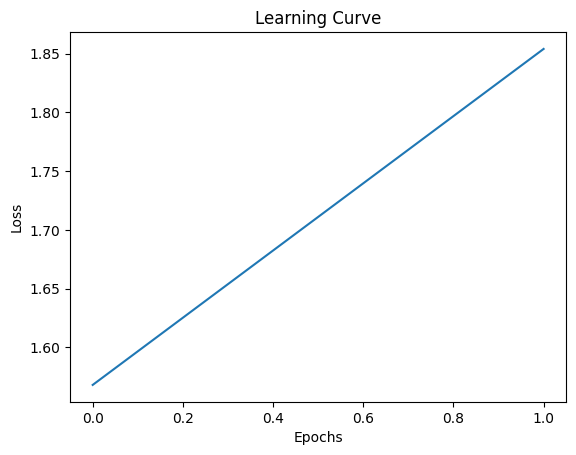

In [ ]:


# Generate data from the room and train a CSCG. Takes about a minute
# nclone = 70
n_emissions = room.max() + 1

a, x, rc = datagen_structured_obs_room(room, length=5000)     #Use length=50000 for bigger room
container = TableContainer()
# n_clones = np.ones(n_emissions, dtype=np.int64) * nclone
chmm = CHMM_LCM(n_clones=n_clones, pseudocount=2e-3, x=x, a=a, container = container, seed=42)  # Initialize the model
progression = chmm.learn_em_T(x, a, n_iter=100)  # Training   use n_iter=1000 for better training


In [ ]:
state_loc = [0,1]
state_loc[0:2]

[0, 1]

In [ ]:
# sys.path.append('naturecomm_cscg')

!pip install cairocffi
!pip install python-igraph==0.9.8

import numpy as np
# from chmm_actions import CHMM, forwardE, datagen_structured_obs_room
import matplotlib.pyplot as plt
import igraph
from matplotlib import cm, colors
import os

custom_colors = (
    np.array(
        [
            [214, 214, 214],
            [85, 35, 157],
            [253, 252, 144],
            [114, 245, 144],
            [151, 38, 20],
            [239, 142, 192],
            [214, 134, 48],
            [140, 194, 250],
            [72, 160, 162],
        ]
    )
    / 256
)
if not os.path.exists("figures"):
    os.makedirs("figures")

In [ ]:
import numpy as np

def generate_custom_colors(num_unique_observations):
    # Define a fixed set of custom colors as RGB values
    predefined_colors = np.array([
        [214, 214, 214],
        [85, 35, 157],
        [253, 252, 144],
        [114, 245, 144],
        [151, 38, 20],
        [239, 142, 192],
        [214, 134, 48],
        [140, 194, 250],
        [72, 160, 162],
    ])

    # If the number of unique observations is greater than the number of predefined colors,
    # cycle through the predefined colors to ensure enough colors are available
    if num_unique_observations > len(predefined_colors):
        extra_colors_needed = num_unique_observations - len(predefined_colors)
        additional_colors = np.tile(predefined_colors, (extra_colors_needed // len(predefined_colors) + 1, 1))
        custom_colors = np.vstack((predefined_colors, additional_colors))[:num_unique_observations]
    else:
        custom_colors = predefined_colors[:num_unique_observations]

    return custom_colors


In [ ]:
## A Few utility functions

def plot_graph(
    chmm, x, a, output_file, cmap=cm.Spectral, multiple_episodes=False, vertex_size=30
):
    states = chmm.decode(x, a)[1]

    v = np.unique(states)
    if multiple_episodes:
        T = chmm.C[:, v][:, :, v][:-1, 1:, 1:]
        v = v[1:]
    else:
        T = chmm.C[:, v][:, :, v]
    A = T.sum(0)
    A /= A.sum(1, keepdims=True)

    g = igraph.Graph.Adjacency((A > 0).tolist())
    node_labels = np.arange(x.max() + 1).repeat(n_clones)[v]
    if multiple_episodes:
        node_labels -= 1
    colors = [cmap(nl)[:3] for nl in node_labels / node_labels.max()]
    out = igraph.plot(
        g,
        output_file,
        layout=g.layout("kamada_kawai"),
        vertex_color=colors,
        vertex_label=v,
        vertex_size=vertex_size,
        margin=50,
    )

    return out, v

def plot_graph_infomap(
    chmm, x, a, output_file, cmap=cm.Spectral, multiple_episodes=False, vertex_size=30
):
    states = chmm.decode(x, a)[1]

    v = np.unique(states)
    if multiple_episodes:
        T = chmm.C[:, v][:, :, v][:-1, 1:, 1:]
        v = v[1:]
    else:
        T = chmm.C[:, v][:, :, v]
    A = T.sum(0)
    A /= A.sum(1, keepdims=True)

    g = igraph.Graph.Adjacency((A > 0).tolist())
    node_labels = np.arange(x.max() + 1).repeat(n_clones)[v]
    if multiple_episodes:
        node_labels -= 1
    colors = [cmap(nl)[:3] for nl in node_labels / node_labels.max()]
    comms = g.community_infomap()
    print(len(comms))

    out = igraph.plot(
        comms,
        output_file,
        layout=g.layout("kamada_kawai"),
        mark_groups=True,
        vertex_label=v,
        vertex_size=vertex_size,
        margin=50,
    )

    return out

def plot_graph_modularity(
    chmm, x, a, output_file, cmap=cm.Spectral, multiple_episodes=False, vertex_size=30
):
    states = chmm.decode(x, a)[1]

    v = np.unique(states)
    if multiple_episodes:
        T = chmm.C[:, v][:, :, v][:-1, 1:, 1:]
        v = v[1:]
    else:
        T = chmm.C[:, v][:, :, v]
    A = T.sum(0)
    A /= A.sum(1, keepdims=True)

    g = igraph.Graph.Adjacency((A > 0).tolist())

    # Convert the directed graph to an undirected graph
    g = g.as_undirected()

    node_labels = np.arange(x.max() + 1).repeat(n_clones)[v]
    if multiple_episodes:
        node_labels -= 1
    colors = [cmap(nl)[:3] for nl in node_labels / node_labels.max()]
    # comms = g.community_infomap()

    # print(len(comms))
    # Detect communities using the Louvain method
    communities = g.community_multilevel()
    print(communities)
    modularity_score = g.modularity(communities)
    print("Modularity Score:", np.round(modularity_score,2))
    # Optionally, visualize the graph with its communities
    out = igraph.plot(communities, output_file, layout=g.layout("kamada_kawai"),
                      mark_groups=True, vertex_label=v, vertex_size=vertex_size, margin=50,)
    # out = igraph.plot(
    #     comms,
    #     output_file,
    #     layout=g.layout("kamada_kawai"),
    #     mark_groups=True,
    #     vertex_label=v,
    #     vertex_size=vertex_size,
    #     margin=50,
    # )

    return out, modularity_score


def get_mess_fwd(chmm, x, pseudocount=0.0, pseudocount_E=0.0):
    n_clones = chmm.n_clones
    E = np.zeros((n_clones.sum(), len(n_clones)))
    last = 0
    for c in range(len(n_clones)):
        E[last : last + n_clones[c], c] = 1
        last += n_clones[c]
    E += pseudocount_E
    norm = E.sum(1, keepdims=True)
    norm[norm == 0] = 1
    E /= norm
    T = chmm.C + pseudocount
    norm = T.sum(2, keepdims=True)
    norm[norm == 0] = 1
    T /= norm
    T = T.mean(0, keepdims=True)
    log2_lik, mess_fwd = forwardE(
        T.transpose(0, 2, 1), E, chmm.Pi_x, chmm.n_clones, x, x * 0, store_messages=True
    )
    return mess_fwd


def place_field(mess_fwd, rc, clone):
    assert mess_fwd.shape[0] == rc.shape[0] and clone < mess_fwd.shape[1]
    field = np.zeros(rc.max(0) + 1)
    count = np.zeros(rc.max(0) + 1, int)
    for t in range(mess_fwd.shape[0]):
        r, c = rc[t]
        field[r, c] += mess_fwd[t, clone]
        count[r, c] += 1
    count[count == 0] = 1
    return field / count



# # JY added for plotting learning curves
# def plot_learning_curve(losses):
#   plt.plot(losses, label='Training Loss')


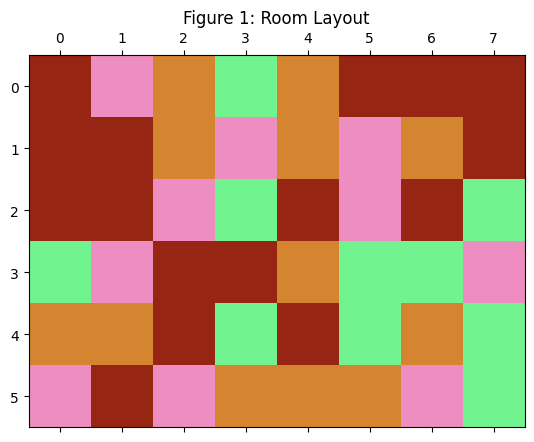

In [ ]:
# room = np.array(
#     [
#         [1, 2, 3, 0, 3,],
#         [1, 1, 3, 2, 3,],
#         [1, 1, 2, 0, 1,],
#         [0, 2, 1, 1, 3,],
#         [3, 3, 1, 0, 1,],
#         [2, 1, 2, 3, 3,],
#     ]
# )

# Uncomment this for generating data from a bigger room. Will take longer to train.

room = np.array(
    [
        [1, 2, 3, 0, 3, 1, 1, 1],
        [1, 1, 3, 2, 3, 2, 3, 1],
        [1, 1, 2, 0, 1, 2, 1, 0],
        [0, 2, 1, 1, 3, 0, 0, 2],
        [3, 3, 1, 0, 1, 0, 3, 0],
        [2, 1, 2, 3, 3, 3, 2, 0],
    ]
)


# Plot the layout of the room
cmap = colors.ListedColormap(custom_colors[-4:])
plt.matshow(room, cmap=cmap)
plt.title('Figure 1: Room Layout')
plt.savefig("figures/rectangular_room_layout.pdf")

In [ ]:
n_clones

array([70, 70, 70, 70])

In [ ]:
# Consolidate learning. Takes a few seconds
chmm.pseudocount = 0.0
chmm.learn_viterbi_T(x, a, n_iter=100)

In [ ]:
# Visualize the learned, consolidated CSCG for the room.

graph = plot_graph(
    chmm, x, a, output_file="figures/rectangular_room_graph.pdf", cmap=cmap
)
graph

# Look for the correspondence between the graph and the original layout of the rooom in Figure 1
# Node colors correspond to the observations from the room. Node numbers are the clone/neuron numbers.

In [ ]:
from IPython.display import display, Image
import igraph

In [ ]:
np.arange(0,1,0.3)

array([0. , 0.3, 0.6, 0.9])

  0%|          | 0/1000 [00:00<?, ?it/s]

Group 0 does not exist.
splitted
Group 1 does not exist.
Group 2 does not exist.
Group 3 does not exist.


  0%|          | 1/1000 [00:04<1:18:59,  4.74s/it, train_bps=2.6]


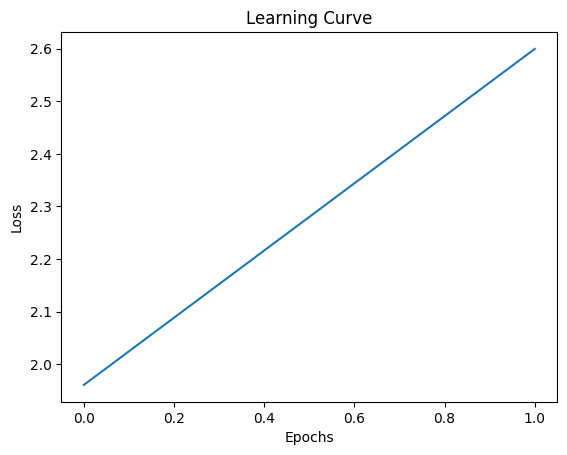

  2%|▏         | 2/100 [00:04<03:16,  2.00s/it, train_bps=1.84]


Ground truth number of nodes: 48, number of nodes recovered 4


<ipython-input-5-03d42a369bb0>:21: RuntimeWarning: invalid value encountered in divide
  colors = [cmap(nl)[:3] for nl in node_labels / node_labels.max()]


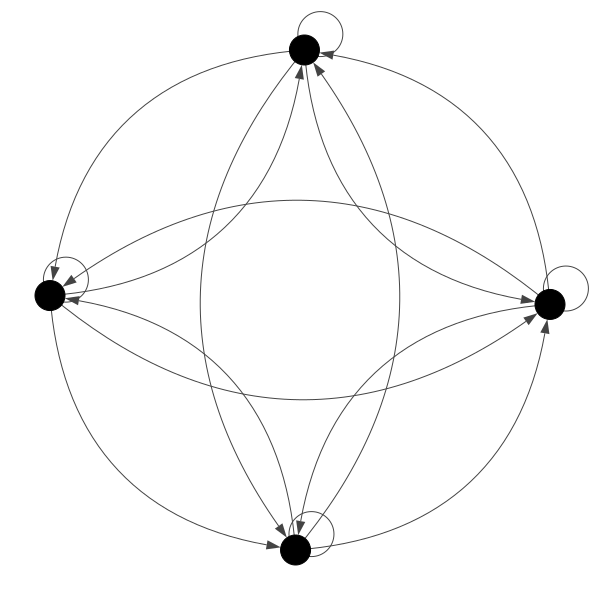

Room 0 has 1 tables (clones)
Room 1 has 1 tables (clones)
Room 2 has 1 tables (clones)
Room 3 has 1 tables (clones)
Total clones used: 4
Clones that would have been used by the original code: 280


  0%|          | 0/1000 [00:00<?, ?it/s]

Group 0 does not exist.
splitted
Group 1 does not exist.
Group 2 does not exist.
Group 3 does not exist.


  0%|          | 1/1000 [00:02<49:52,  3.00s/it, train_bps=2.6]


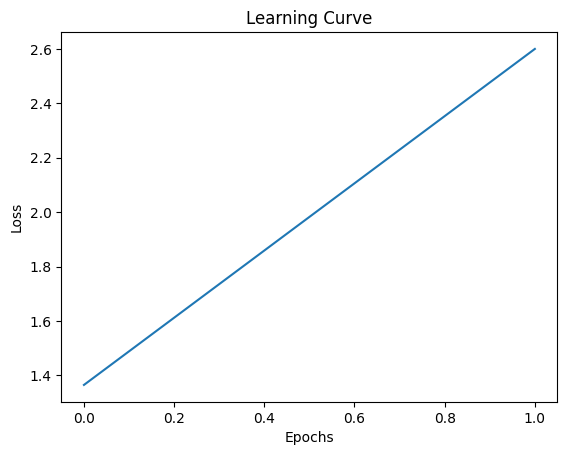

  2%|▏         | 2/100 [00:03<02:47,  1.71s/it, train_bps=1.84]


Ground truth number of nodes: 48, number of nodes recovered 4


<ipython-input-5-03d42a369bb0>:21: RuntimeWarning: invalid value encountered in divide
  colors = [cmap(nl)[:3] for nl in node_labels / node_labels.max()]


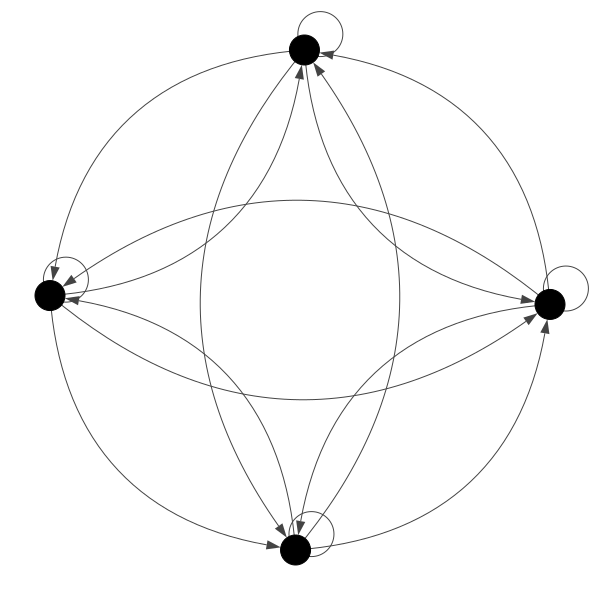

Room 0 has 3 tables (clones)
Room 1 has 2 tables (clones)
Room 2 has 2 tables (clones)
Room 3 has 3 tables (clones)
Total clones used: 10
Clones that would have been used by the original code: 280


  0%|          | 0/1000 [00:00<?, ?it/s]

Group 0 does not exist.
splitted
Group 1 does not exist.
Group 2 does not exist.
Group 3 does not exist.


  0%|          | 1/1000 [00:01<30:47,  1.85s/it, train_bps=1.56]


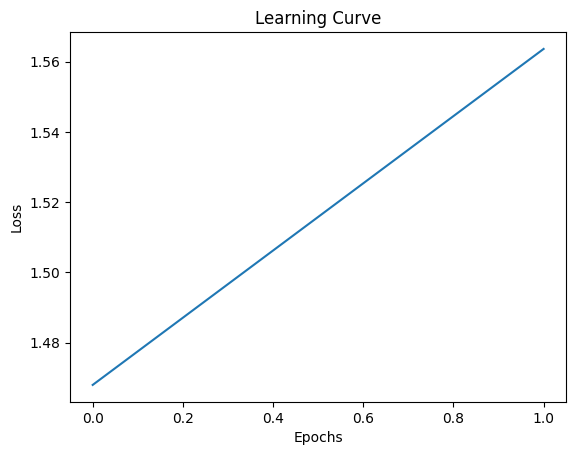

  2%|▏         | 2/100 [00:01<01:13,  1.33it/s, train_bps=1.84]


Ground truth number of nodes: 48, number of nodes recovered 4


<ipython-input-5-03d42a369bb0>:21: RuntimeWarning: invalid value encountered in divide
  colors = [cmap(nl)[:3] for nl in node_labels / node_labels.max()]


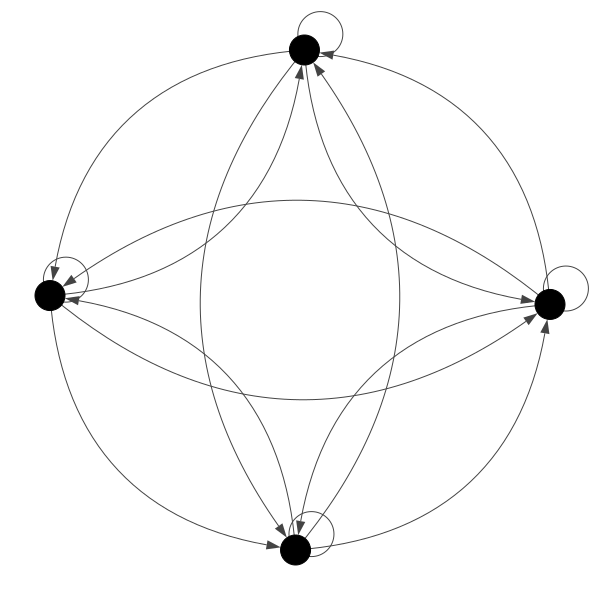

Room 0 has 5 tables (clones)
Room 1 has 6 tables (clones)
Room 2 has 5 tables (clones)
Room 3 has 5 tables (clones)
Total clones used: 21
Clones that would have been used by the original code: 280


  0%|          | 0/1000 [00:00<?, ?it/s]

Group 0 does not exist.
splitted
Group 1 does not exist.
Group 2 does not exist.
Group 3 does not exist.


  0%|          | 1/1000 [00:01<30:29,  1.83s/it, train_bps=1.81]


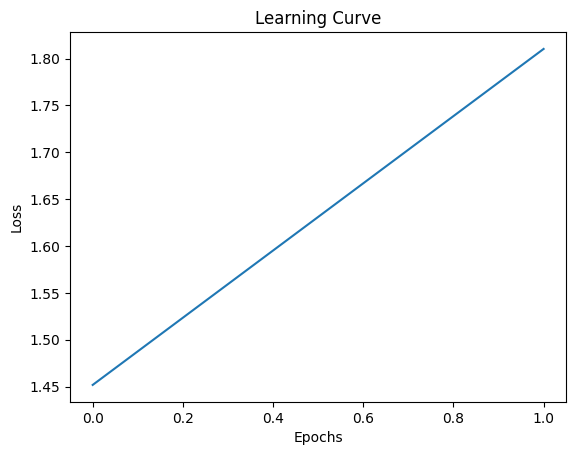

  2%|▏         | 2/100 [00:02<02:22,  1.46s/it, train_bps=1.84]


Ground truth number of nodes: 48, number of nodes recovered 4


<ipython-input-5-03d42a369bb0>:21: RuntimeWarning: invalid value encountered in divide
  colors = [cmap(nl)[:3] for nl in node_labels / node_labels.max()]


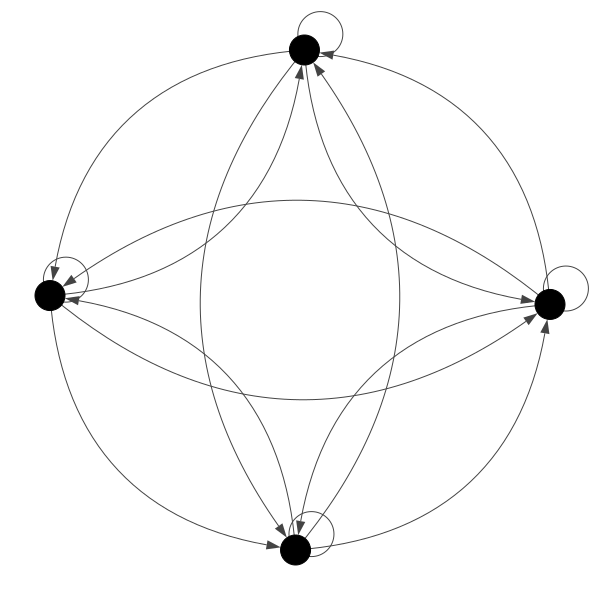

Room 0 has 9 tables (clones)
Room 1 has 7 tables (clones)
Room 2 has 10 tables (clones)
Room 3 has 13 tables (clones)
Total clones used: 39
Clones that would have been used by the original code: 280


In [ ]:
# Generate data from the room and train a CSCG. Takes about a minute
# clones = np.arange(10, 220, 50)
# clones=[70]
# nclone = 70
n_emissions = room.max() + 1

a, x, rc = datagen_structured_obs_room(room, length=5000)     #Use length=50000 for bigger room
# for nclone in clones:
for alpha in np.arange(0,1,0.3):
  n_clones = np.ones(n_emissions, dtype=np.int64) * nclone
  container = TableContainer()
  chmm = CHMM_LCM(n_clones=n_clones, pseudocount=2e-3, x=x, a=a, container=container,alpha=alpha,seed=42)  # Initialize the model
  progression = chmm.learn_em_T(x, a, n_iter=1000)  # Training   use n_iter=1000 for better training
  # progression = chmm.learn_em_E(x, a, n_iter=1000)  # Training   use n_iter=1000 for better training

  # Consolidate learning. Takes a few seconds
  chmm.pseudocount = 0.0
  chmm.learn_viterbi_T(x, a, n_iter=100)

  # graph = plot_graph(
  #     chmm, x, a, output_file="figures/rectangular_room_graph.pdf", cmap=cmap
  # )
  # graph

  # cmap = colors.ListedColormap(custom_colors[arr])

  temp_output_file = f"rectangular_room_graph_large_num_clones_{nclone}.png"  # Temporary file for each clone
  graph, v = plot_graph(chmm, x, a, output_file=temp_output_file, cmap=cmap)
  print('Ground truth number of nodes: {}, number of nodes recovered {}'.format(len(room.flatten()), len(v)))





  # Display the image inline
  display(Image(filename=temp_output_file))



  n_clones = 0
  for roomid in range(len(container.groups_of_tables)):
    print("Room {} has {} tables (clones)".format(roomid, len(container.groups_of_tables[roomid])))
    n_clones+=len(container.groups_of_tables[roomid])
  print("Total clones used: {}".format(n_clones))
  print("Clones that would have been used by the original code: {}".format(len(container.groups_of_tables) * 70))


In [ ]:
chmm.decode(x,a)[2]

In [ ]:
# return -log2_lik, states, mess_fwd
ginis = chmm.decode(x,a)[1]
np.shape(ginis)

In [ ]:
np.unique(ginis)


In [ ]:
plt.hist(ginis)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import random

# Function to create a lattice graph with variable nodes, observations, and aliased states
def create_modular_graph_varied(num_nodes=15, num_observations=10000, num_aliased_states=10, num_modules=3):
    if num_nodes < 4:
        raise ValueError("num_nodes must be at least 4 to allow for meaningful connectivity.")

    if num_nodes < num_modules:
        raise ValueError("Number of nodes must be at least equal to the number of modules to form a meaningful structure.")

    # Initialize the adjacency matrix
    T = np.zeros((num_nodes, num_nodes))

    # Calculate the size of each module
    module_size = num_nodes // num_modules

    for module_index in range(num_modules):
        module_start = module_index * module_size
        # For the last module, extend to the end of the node list
        module_end = module_start + module_size if module_index < num_modules - 1 else num_nodes

        # Fully connect nodes within the module
        for i in range(module_start, module_end):
            for j in range(module_start, module_end):
                if i != j:
                    T[i, j] = 1.0
    # Optionally, add sparse inter-module connections
    # Example: Connecting last node of one module to first node of the next module
    for module_index in range(num_modules - 1):
        module_end = (module_index + 1) * module_size - 1
        next_module_start = (module_end + 1) % num_nodes
        T[module_end, next_module_start] = 1.0
        T[next_module_start, module_end] = 1.0
    # connect first and last module
    T[0, num_nodes-1] = 1.0
    T[num_nodes-1,0] = 1.0



    # Generate observations based on random walks on the lattice graph
    states = [np.random.choice(range(num_nodes))]  # Start from a random state
    for _ in range(1, num_observations):
        current_state = states[-1]
        possible_next_states = np.where(T[current_state, :] > 0)[0]
        next_state = np.random.choice(possible_next_states)
        states.append(next_state)


    # Map states to observations with aliasing
    if num_aliased_states > num_nodes or num_aliased_states < 1:
        raise ValueError("num_aliased_states must be between 1 and the number of nodes.")


    unique_obs = np.arange(num_nodes - num_aliased_states)
    for n in range(num_aliased_states):
      unique_obs = np.append(unique_obs,random.choice(unique_obs))
    state_to_obs = unique_obs # Aliasing version

    # Create observation data
    x = state_to_obs[states]

    plt.matshow(T)
    plt.show()

    return x

# Function to create a lattice graph with variable nodes, observations, and aliased states
def create_lattice_graph_varied(num_nodes=15, num_observations=10000, num_aliased_states=10):
    if num_nodes < 4:
        raise ValueError("num_nodes must be at least 4 to allow for meaningful connectivity.")

    # Initialize the adjacency matrix
    T = np.zeros((num_nodes, num_nodes))

    # Connect each node to its immediate and second-order neighbors with wrapping
    for i in range(num_nodes):
        for offset in [-2, -1, 1, 2]:  # Immediate and second-order neighbors
            j = (i + offset) % num_nodes
            T[i, j] = 1.0

    # Generate observations based on random walks on the lattice graph
    states = [np.random.choice(range(num_nodes))]  # Start from a random state
    for _ in range(1, num_observations):
        current_state = states[-1]
        possible_next_states = np.where(T[current_state, :] > 0)[0]
        next_state = np.random.choice(possible_next_states)
        states.append(next_state)


    # Map states to observations with aliasing
    if num_aliased_states > num_nodes or num_aliased_states < 1:
        raise ValueError("num_aliased_states must be between 1 and the number of nodes.")


    unique_obs = np.arange(num_nodes - num_aliased_states)
    for n in range(num_aliased_states):
      unique_obs = np.append(unique_obs,random.choice(unique_obs))
    state_to_obs = unique_obs # Aliasing version

    # Create observation data
    x = state_to_obs[states]

    plt.matshow(T)

    return x

In [ ]:
num_nodes//aliasing

50 nodes, 12 aliased states, 3 modules, 0.0 alpha


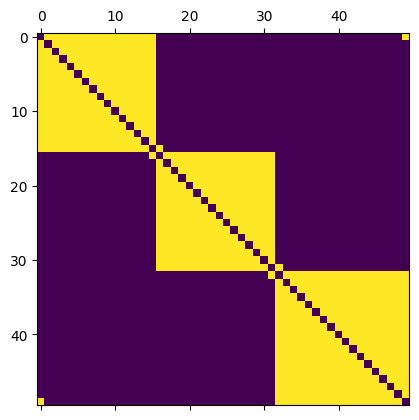

  0%|          | 0/1000 [00:00<?, ?it/s]

Group 0 does not exist.
splitted
Group 1 does not exist.
Group 2 does not exist.
Group 3 does not exist.
Group 4 does not exist.
Group 5 does not exist.
Group 6 does not exist.
Group 7 does not exist.
Group 8 does not exist.
Group 9 does not exist.
Group 10 does not exist.
Group 11 does not exist.
Group 12 does not exist.
Group 13 does not exist.
Group 14 does not exist.
Group 15 does not exist.
Group 16 does not exist.
Group 17 does not exist.
Group 18 does not exist.
Group 19 does not exist.
Group 20 does not exist.
Group 21 does not exist.
Group 22 does not exist.
Group 23 does not exist.
Group 24 does not exist.
Group 25 does not exist.
Group 26 does not exist.
Group 27 does not exist.
Group 28 does not exist.
Group 29 does not exist.
Group 30 does not exist.
Group 31 does not exist.
Group 32 does not exist.
Group 33 does not exist.
Group 34 does not exist.
Group 35 does not exist.
Group 36 does not exist.
Group 37 does not exist.


  0%|          | 1/1000 [00:04<1:09:37,  4.18s/it, train_bps=7.44]


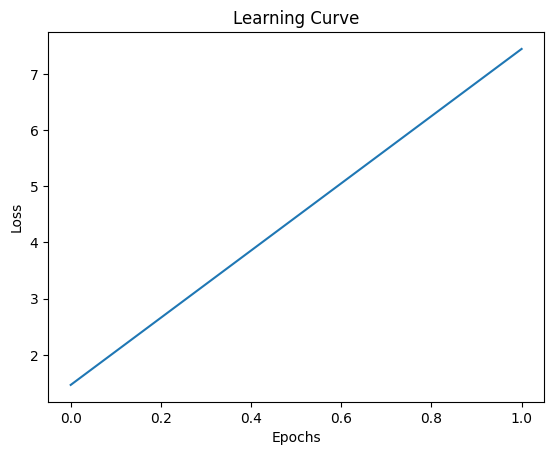

  2%|▏         | 2/100 [00:03<02:28,  1.52s/it, train_bps=3.99]


Clustering with 38 elements and 3 clusters
[0] 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15
[1] 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31
[2] 32, 33, 34, 35, 36, 37
Modularity Score: 0.42


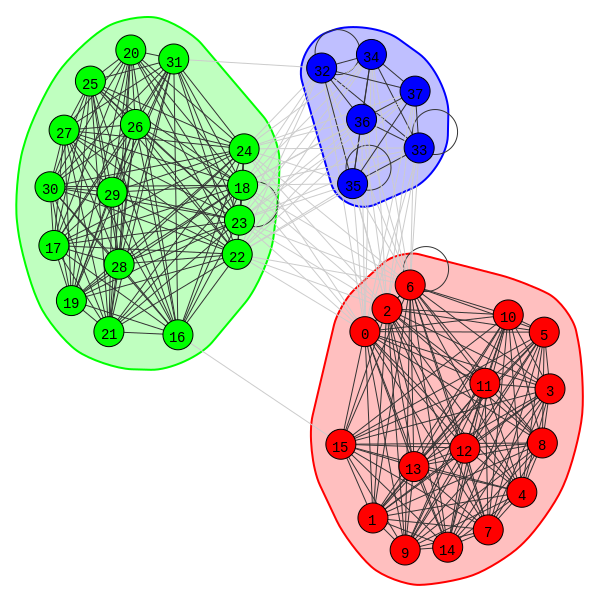

Room 0 has 1 tables (clones)
Room 1 has 1 tables (clones)
Room 2 has 1 tables (clones)
Room 3 has 1 tables (clones)
Room 4 has 1 tables (clones)
Room 5 has 1 tables (clones)
Room 6 has 1 tables (clones)
Room 7 has 1 tables (clones)
Room 8 has 1 tables (clones)
Room 9 has 1 tables (clones)
Room 10 has 1 tables (clones)
Room 11 has 1 tables (clones)
Room 12 has 1 tables (clones)
Room 13 has 1 tables (clones)
Room 14 has 1 tables (clones)
Room 15 has 1 tables (clones)
Room 16 has 1 tables (clones)
Room 17 has 1 tables (clones)
Room 18 has 1 tables (clones)
Room 19 has 1 tables (clones)
Room 20 has 1 tables (clones)
Room 21 has 1 tables (clones)
Room 22 has 1 tables (clones)
Room 23 has 1 tables (clones)
Room 24 has 1 tables (clones)
Room 25 has 1 tables (clones)
Room 26 has 1 tables (clones)
Room 27 has 1 tables (clones)
Room 28 has 1 tables (clones)
Room 29 has 1 tables (clones)
Room 30 has 1 tables (clones)
Room 31 has 1 tables (clones)
Room 32 has 1 tables (clones)
Room 33 has 1 tables

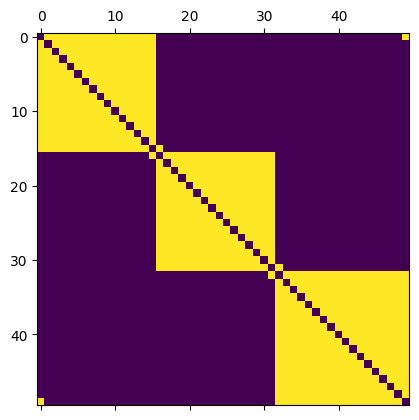

  0%|          | 0/1000 [00:00<?, ?it/s]

Group 0 does not exist.
splitted
Group 1 does not exist.
Group 2 does not exist.
Group 3 does not exist.
Group 4 does not exist.
Group 5 does not exist.
Group 6 does not exist.
Group 7 does not exist.
Group 8 does not exist.
Group 9 does not exist.
Group 10 does not exist.
Group 11 does not exist.
Group 12 does not exist.
Group 13 does not exist.
Group 14 does not exist.
Group 15 does not exist.
Group 16 does not exist.
Group 17 does not exist.
Group 18 does not exist.
Group 19 does not exist.
Group 20 does not exist.
Group 21 does not exist.
Group 22 does not exist.
Group 23 does not exist.
Group 24 does not exist.
Group 25 does not exist.
Group 26 does not exist.
Group 27 does not exist.
Group 28 does not exist.
Group 29 does not exist.
Group 30 does not exist.
Group 31 does not exist.
Group 32 does not exist.
Group 33 does not exist.
Group 34 does not exist.
Group 35 does not exist.
Group 36 does not exist.
Group 37 does not exist.


  0%|          | 1/1000 [00:05<1:23:56,  5.04s/it, train_bps=3.84]


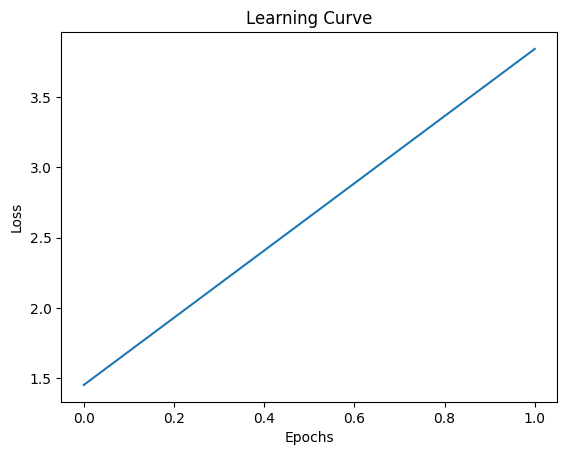

  2%|▏         | 2/100 [00:04<03:20,  2.05s/it, train_bps=4.02]


Clustering with 38 elements and 3 clusters
[0] 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15
[1] 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31
[2] 32, 33, 34, 35, 36, 37
Modularity Score: 0.4


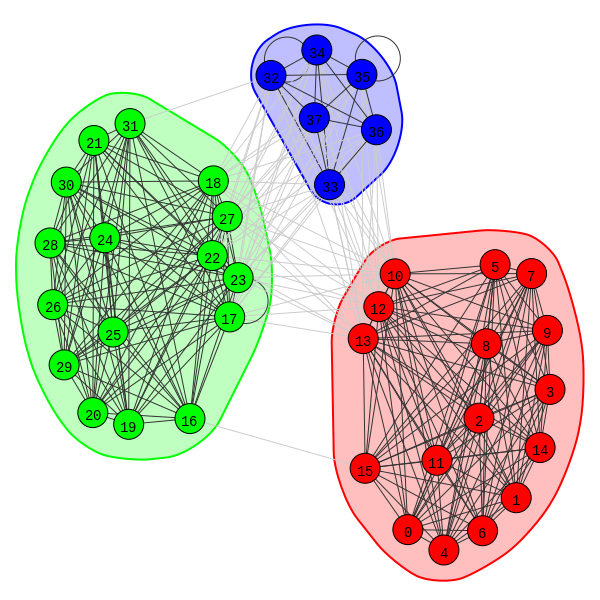

Room 0 has 2 tables (clones)
Room 1 has 5 tables (clones)
Room 2 has 3 tables (clones)
Room 3 has 2 tables (clones)
Room 4 has 3 tables (clones)
Room 5 has 2 tables (clones)
Room 6 has 4 tables (clones)
Room 7 has 2 tables (clones)
Room 8 has 4 tables (clones)
Room 9 has 1 tables (clones)
Room 10 has 4 tables (clones)
Room 11 has 5 tables (clones)
Room 12 has 3 tables (clones)
Room 13 has 1 tables (clones)
Room 14 has 1 tables (clones)
Room 15 has 8 tables (clones)
Room 16 has 3 tables (clones)
Room 17 has 5 tables (clones)
Room 18 has 1 tables (clones)
Room 19 has 2 tables (clones)
Room 20 has 4 tables (clones)
Room 21 has 4 tables (clones)
Room 22 has 2 tables (clones)
Room 23 has 3 tables (clones)
Room 24 has 2 tables (clones)
Room 25 has 4 tables (clones)
Room 26 has 2 tables (clones)
Room 27 has 4 tables (clones)
Room 28 has 4 tables (clones)
Room 29 has 5 tables (clones)
Room 30 has 5 tables (clones)
Room 31 has 2 tables (clones)
Room 32 has 2 tables (clones)
Room 33 has 2 tables

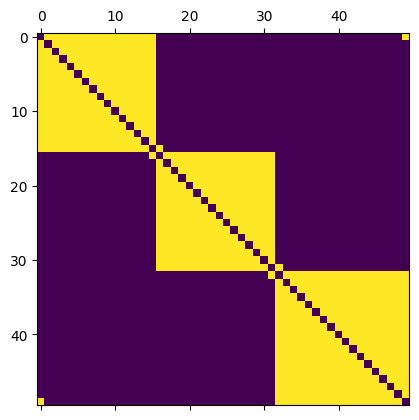

  0%|          | 0/1000 [00:00<?, ?it/s]

Group 0 does not exist.
splitted
Group 1 does not exist.
Group 2 does not exist.
Group 3 does not exist.
Group 4 does not exist.
Group 5 does not exist.
Group 6 does not exist.
Group 7 does not exist.
Group 8 does not exist.
Group 9 does not exist.
Group 10 does not exist.
Group 11 does not exist.
Group 12 does not exist.
Group 13 does not exist.
Group 14 does not exist.
Group 15 does not exist.
Group 16 does not exist.
Group 17 does not exist.
Group 18 does not exist.
Group 19 does not exist.
Group 20 does not exist.
Group 21 does not exist.
Group 22 does not exist.
Group 23 does not exist.
Group 24 does not exist.
Group 25 does not exist.
Group 26 does not exist.
Group 27 does not exist.
Group 28 does not exist.
Group 29 does not exist.
Group 30 does not exist.
Group 31 does not exist.
Group 32 does not exist.
Group 33 does not exist.
Group 34 does not exist.
Group 35 does not exist.
Group 36 does not exist.
Group 37 does not exist.


  0%|          | 1/1000 [00:07<2:12:56,  7.98s/it, train_bps=2.56]


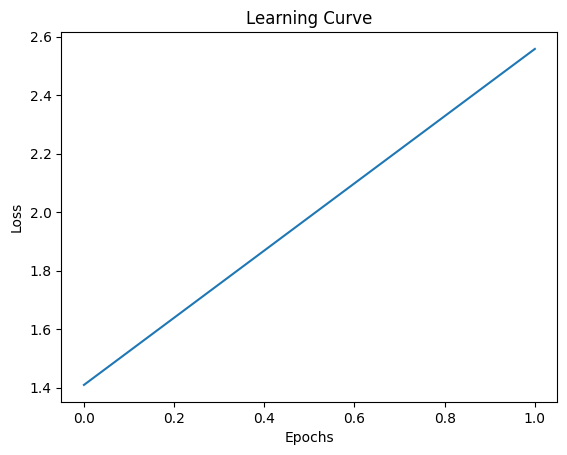

  2%|▏         | 2/100 [00:03<02:37,  1.61s/it, train_bps=3.91]


Clustering with 38 elements and 2 clusters
[0] 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15
[1] 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
    34, 35, 36, 37
Modularity Score: 0.44


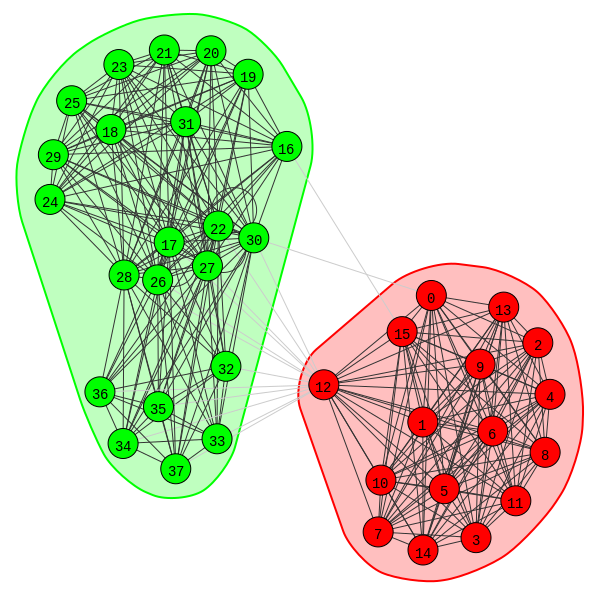

Room 0 has 4 tables (clones)
Room 1 has 5 tables (clones)
Room 2 has 4 tables (clones)
Room 3 has 3 tables (clones)
Room 4 has 4 tables (clones)
Room 5 has 6 tables (clones)
Room 6 has 4 tables (clones)
Room 7 has 5 tables (clones)
Room 8 has 5 tables (clones)
Room 9 has 6 tables (clones)
Room 10 has 4 tables (clones)
Room 11 has 5 tables (clones)
Room 12 has 2 tables (clones)
Room 13 has 5 tables (clones)
Room 14 has 3 tables (clones)
Room 15 has 5 tables (clones)
Room 16 has 6 tables (clones)
Room 17 has 8 tables (clones)
Room 18 has 6 tables (clones)
Room 19 has 5 tables (clones)
Room 20 has 6 tables (clones)
Room 21 has 3 tables (clones)
Room 22 has 5 tables (clones)
Room 23 has 1 tables (clones)
Room 24 has 4 tables (clones)
Room 25 has 8 tables (clones)
Room 26 has 4 tables (clones)
Room 27 has 8 tables (clones)
Room 28 has 9 tables (clones)
Room 29 has 4 tables (clones)
Room 30 has 4 tables (clones)
Room 31 has 8 tables (clones)
Room 32 has 7 tables (clones)
Room 33 has 5 tables

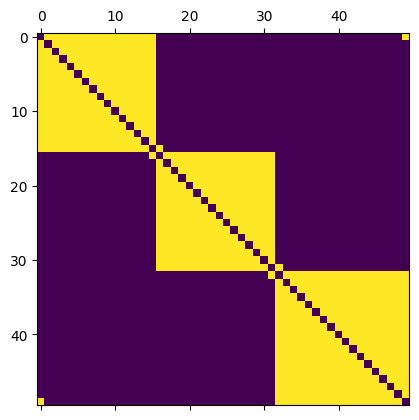

  0%|          | 0/1000 [00:00<?, ?it/s]

Group 0 does not exist.
splitted
Group 1 does not exist.
Group 2 does not exist.
Group 3 does not exist.
Group 4 does not exist.
Group 5 does not exist.
Group 6 does not exist.
Group 7 does not exist.
Group 8 does not exist.
Group 9 does not exist.
Group 10 does not exist.
Group 11 does not exist.
Group 12 does not exist.
Group 13 does not exist.
Group 14 does not exist.
Group 15 does not exist.
Group 16 does not exist.
Group 17 does not exist.
Group 18 does not exist.
Group 19 does not exist.
Group 20 does not exist.
Group 21 does not exist.
Group 22 does not exist.
Group 23 does not exist.
Group 24 does not exist.
Group 25 does not exist.
Group 26 does not exist.
Group 27 does not exist.
Group 28 does not exist.
Group 29 does not exist.
Group 30 does not exist.
Group 31 does not exist.
Group 32 does not exist.
Group 33 does not exist.
Group 34 does not exist.
Group 35 does not exist.
Group 36 does not exist.
Group 37 does not exist.


  0%|          | 1/1000 [00:09<2:41:42,  9.71s/it, train_bps=1.99]


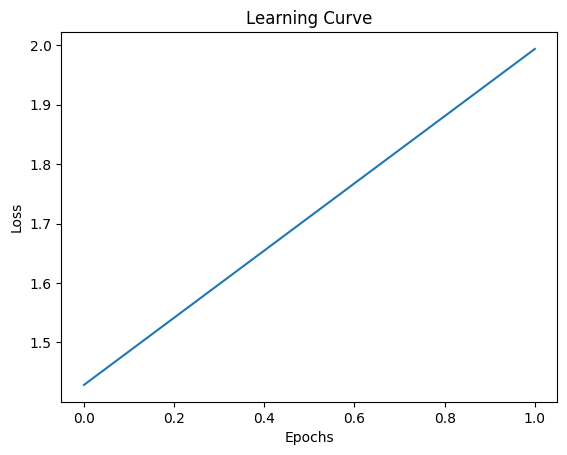

  2%|▏         | 2/100 [00:03<03:06,  1.90s/it, train_bps=4.05]


Clustering with 38 elements and 3 clusters
[0] 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15
[1] 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31
[2] 32, 33, 34, 35, 36, 37
Modularity Score: 0.4


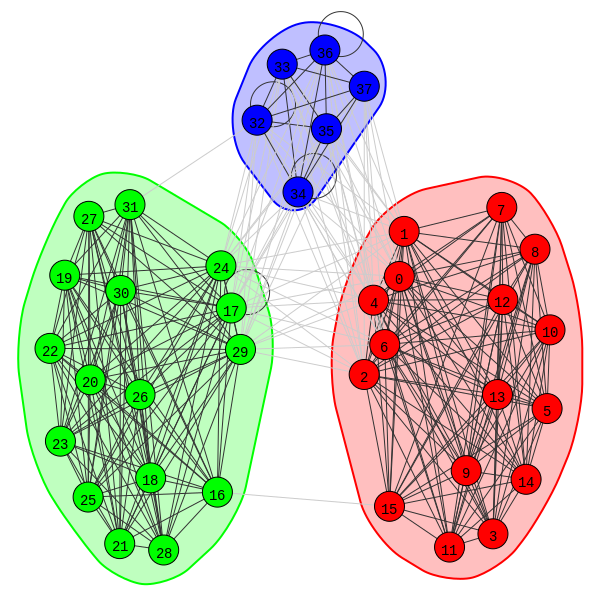

Room 0 has 4 tables (clones)
Room 1 has 4 tables (clones)
Room 2 has 4 tables (clones)
Room 3 has 10 tables (clones)
Room 4 has 8 tables (clones)
Room 5 has 8 tables (clones)
Room 6 has 9 tables (clones)
Room 7 has 7 tables (clones)
Room 8 has 8 tables (clones)
Room 9 has 8 tables (clones)
Room 10 has 6 tables (clones)
Room 11 has 10 tables (clones)
Room 12 has 7 tables (clones)
Room 13 has 5 tables (clones)
Room 14 has 8 tables (clones)
Room 15 has 6 tables (clones)
Room 16 has 3 tables (clones)
Room 17 has 13 tables (clones)
Room 18 has 4 tables (clones)
Room 19 has 7 tables (clones)
Room 20 has 7 tables (clones)
Room 21 has 5 tables (clones)
Room 22 has 3 tables (clones)
Room 23 has 5 tables (clones)
Room 24 has 7 tables (clones)
Room 25 has 6 tables (clones)
Room 26 has 4 tables (clones)
Room 27 has 9 tables (clones)
Room 28 has 3 tables (clones)
Room 29 has 3 tables (clones)
Room 30 has 6 tables (clones)
Room 31 has 7 tables (clones)
Room 32 has 8 tables (clones)
Room 33 has 7 tab

In [ ]:
# var_nodes = np.arange(5,50,5)
num_nodes = 50
num_observations = 10000
num_aliased_states = 2  # Adjust this to change the number of aliased states
num_clones = 10
num_modules=3
var_clones = np.arange(1,15,1)
total_modularity_scores = []
var_aliasing = np.arange(2,4,1)
# for num_clones in var_clones:
modularity_scores = []
# for aliasing in var_aliasing:
for alpha in np.arange(0,1,0.3):
  aliasing = 4

  num_aliased_states = num_nodes//aliasing  # Adjust this to change the number of aliased states

  #1. MODULAR GRAPH
  # print("modular graph".format(num_clones))
  print("{} nodes, {} aliased states, {} modules, {} alpha".format(num_nodes, num_aliased_states,num_modules, alpha))

  # Create observation data
  x = create_modular_graph_varied(num_nodes, num_observations, num_aliased_states, num_modules)
  a = np.zeros(len(x), dtype=int)

  n_clones = np.ones(max(x)+1, dtype=np.int64) * num_clones
  container = TableContainer()
  chmm = CHMM_LCM(n_clones=n_clones, pseudocount=2e-3, x=x, a=a, container = container, alpha=alpha, seed=42)  # Initialize the model
  progression = chmm.learn_em_T(x, a, n_iter=1000)  # Training

  # refine learning
  chmm.pseudocount = 0.0
  chmm.learn_viterbi_T(x, a, n_iter=100)
  states = chmm.decode(x, a)[1]
  n_states = len(np.unique(states))

  custom_colors = generate_custom_colors(max(x)+1)/256
  arr = np.arange(max(x)+1)
  np.random.shuffle(arr)
  cmap = colors.ListedColormap(custom_colors[arr])

  temp_output_file = f"modular_graph_num_nodes_{num_nodes}.png"  # Temporary file for each clone
  graph, modularity_score = plot_graph_modularity(chmm, x, a, output_file=temp_output_file, cmap=cmap)
  # print('Ground truth number of nodes: {}, number of nodes recovered {}'.format(num_nodes, len(v)))
  # Display the image inline
  display(Image(filename=temp_output_file))

  modularity_scores.append(modularity_score)

  n_clones = 0
  for roomid in range(len(container.groups_of_tables)):
    print("Room {} has {} tables (clones)".format(roomid, len(container.groups_of_tables[roomid])))
    n_clones+=len(container.groups_of_tables[roomid])
  print("Total clones used: {}".format(n_clones))
  print("Clones that would have been used by the original code: {}".format(len(container.groups_of_tables) * 5))

total_modularity_scores.append(modularity_scores)


  # #2. LATTICE GRAPH
  # print("{} clones: lattice graph".format(num_clones))
  # print("{} nodes, {} aliased states".format(num_nodes, num_aliased_states))

  # # Create observation data
  # x = create_lattice_graph_varied(num_nodes, num_observations, num_aliased_states)
  # a = np.zeros(len(x), dtype=int)

  # n_clones = np.ones(max(x)+1, dtype=np.int64) * num_clones
  # chmm = CHMM(n_clones=n_clones, pseudocount=1.0, x=x, a=a)  # Initialize the model
  # progression = chmm.learn_em_T(x, a, n_iter=1000)  # Training

  # # refine learning
  # chmm.pseudocount = 0.0
  # chmm.learn_viterbi_T(x, a, n_iter=100)
  # states = chmm.decode(x, a)[1]
  # n_states = len(np.unique(states))
  # n_states

  # custom_colors = generate_custom_colors(max(x)+1)/256
  # arr = np.arange(max(x)+1)
  # np.random.shuffle(arr)

  # cmap = colors.ListedColormap(custom_colors[arr])

  # temp_output_file = f"lattice_graph_num_clones_{num_clones}.png"  # Temporary file for each clone
  # graph, v = plot_graph(chmm, x, a, output_file=temp_output_file, cmap=cmap)
  # print('Ground truth number of nodes: {}, number of nodes recovered {}'.format(num_nodes, len(v)))
  # # Display the image inline
  # display(Image(filename=temp_output_file))



In [ ]:
container.get_group_total(0)

840

In [ ]:
container.groups_of_tables

{0: {1: 725, 2: 95, 3: 6, 4: 8, 5: 5, 6: 1},
 1: {1: 542, 2: 170, 3: 13, 4: 10, 5: 5},
 2: {1: 592, 2: 84, 3: 9, 4: 5},
 3: {1: 766, 2: 30},
 4: {1: 146, 2: 52, 3: 175, 4: 19, 5: 4},
 5: {1: 683, 2: 41, 3: 2},
 6: {1: 410, 2: 488, 3: 6, 4: 2},
 7: {1: 1072, 2: 34, 3: 1, 4: 7, 5: 6},
 8: {1: 711, 2: 10, 3: 5, 4: 2},
 9: {1: 418, 2: 2},
 10: {1: 1048, 2: 35, 3: 15, 4: 20, 5: 8},
 11: {1: 737, 2: 57, 3: 16, 4: 26},
 12: {1: 962, 2: 211, 3: 1},
 13: {1: 714, 2: 12, 3: 1, 4: 2, 5: 1},
 14: {1: 742, 2: 8, 3: 2},
 15: {1: 326, 2: 6, 3: 10, 4: 1, 5: 17, 6: 2, 7: 6, 8: 1, 9: 1},
 16: {1: 210, 2: 147, 3: 9, 4: 10},
 17: {1: 202, 2: 129, 3: 9, 4: 4, 5: 6, 6: 12, 7: 1, 8: 1},
 18: {1: 25, 2: 256, 3: 19, 4: 68, 5: 13, 6: 5},
 19: {1: 310, 2: 64, 3: 1, 4: 1},
 20: {1: 233, 2: 165},
 21: {1: 61, 2: 333},
 22: {1: 320, 2: 26, 3: 30},
 23: {1: 273, 2: 17, 3: 2, 4: 20, 5: 40, 6: 4},
 24: {1: 517, 2: 4, 3: 3, 4: 4},
 25: {1: 330, 2: 89, 3: 8, 4: 16, 5: 1},
 26: {1: 354, 2: 18, 3: 8, 4: 5, 5: 33, 6: 10},


In [ ]:
len(container.groups_of_tables[0])

6

In [ ]:
n_clones = 0
for roomid in range(len(container.groups_of_tables)):
  print("Room {} has {} tables (clones)".format(roomid, len(container.groups_of_tables[roomid])))
  n_clones+=len(container.groups_of_tables[roomid])
print("Total clones used: {}".format(n_clones))
print("Clones that would have been used by the original code: {}".format(len(container.groups_of_tables) * 5))

Room 0 has 6 tables (clones)
Room 1 has 5 tables (clones)
Room 2 has 4 tables (clones)
Room 3 has 2 tables (clones)
Room 4 has 5 tables (clones)
Room 5 has 3 tables (clones)
Room 6 has 4 tables (clones)
Room 7 has 5 tables (clones)
Room 8 has 4 tables (clones)
Room 9 has 2 tables (clones)
Room 10 has 5 tables (clones)
Room 11 has 4 tables (clones)
Room 12 has 3 tables (clones)
Room 13 has 5 tables (clones)
Room 14 has 3 tables (clones)
Room 15 has 9 tables (clones)
Room 16 has 4 tables (clones)
Room 17 has 8 tables (clones)
Room 18 has 6 tables (clones)
Room 19 has 4 tables (clones)
Room 20 has 2 tables (clones)
Room 21 has 2 tables (clones)
Room 22 has 3 tables (clones)
Room 23 has 6 tables (clones)
Room 24 has 4 tables (clones)
Room 25 has 5 tables (clones)
Room 26 has 6 tables (clones)
Room 27 has 6 tables (clones)
Room 28 has 3 tables (clones)
Room 29 has 5 tables (clones)
Room 30 has 5 tables (clones)
Room 31 has 5 tables (clones)
Room 32 has 4 tables (clones)
Room 33 has 5 tables

In [ ]:
container.get_group_total(0)

In [ ]:
clones = np.arange(1,20)

T = np.zeros((15, 15))
# Connect cliques
for i in range(0, 4 + 1):
    for j in range(0, 4 + 1):
        if i != j:
            T[i, j] = 1.0
for i in range(5, 9 + 1):
    for j in range(5, 9 + 1):
        if i != j:
            T[i, j] = 1.0
for i in range(10, 14 + 1):
    for j in range(10, 14 + 1):
        if i != j:
            T[i, j] = 1.0
# Disconnect in clique connector nodes
T[0, 4] = 0.0
T[4, 0] = 0.0
T[5, 9] = 0.0
T[9, 5] = 0.0
T[10, 14] = 0.0
T[14, 10] = 0.0
# Connect cross clique connector nodes
T[4, 5] = 1.0
T[5, 4] = 1.0
T[9, 10] = 1.0
T[10, 9] = 1.0
T[14, 0] = 1.0
T[0, 14] = 1.0
plt.matshow(T)
plt.show()


# Draw data
states = [0]
for _ in range(10000):
    prev_state = states[-1]

    possible_next_states = np.where(T[prev_state, :])[0]
    next_state = np.random.choice(possible_next_states)
    states.append(next_state)
states = np.array(states)

state_to_obs = (
    np.array([1, 2, 3, 4, 5, 6, 1, 4, 5, 2, 8, 2, 3, 5, 7], dtype=int) - 1
)  # Aliasing version

# Create observation data
x = state_to_obs[states]
a = np.zeros(len(x), dtype=int)


for clone in clones:


  n_clones = np.ones(8, dtype=np.int64) * clone
  chmm = CHMM(n_clones=n_clones, pseudocount=1.0, x=x, a=a)  # Initialize the model
  progression = chmm.learn_em_T(x, a, n_iter=1000)  # Training


  # refine learning
  chmm.pseudocount = 0.0
  chmm.learn_viterbi_T(x, a, n_iter=100)
  loglik, states, ginis = chmm.decode(x, a)
  plt.hist(ginis)
  plt.show()
  n_states = len(np.unique(states))
  n_states

  cmap = colors.ListedColormap(custom_colors[[7, 3, 2, 1, 5, 0, 4, 6]])
  # graph = plot_graph(chmm, x, a, output_file="figures/pentagonal_cliques.pdf", cmap=cmap)


  temp_output_file = f"temp_figure_{clone}.png"  # Temporary file for each clone
  # graph = plot_graph_infomap(chmm, x, a, output_file=temp_output_file, cmap=cmap)
  graph = plot_graph_modularity(chmm, x, a, output_file=temp_output_file, cmap=cmap)

  # Display the image inline
  display(Image(filename=temp_output_file))





  # print(graph)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def create_clique_matrix(num_cliques, clique_size=5, visualize=False):
    # Calculate the total size of the matrix
    total_size = num_cliques * clique_size
    T = np.zeros((total_size, total_size))

    # Connect nodes within each clique
    for n in range(num_cliques):
        start_index = n * clique_size
        end_index = start_index + clique_size
        for i in range(start_index, end_index):
            for j in range(start_index, end_index):
                if i != j:
                    T[i, j] = 1.0

    # Disconnect in-clique connector nodes and connect cross-clique connector nodes
    for n in range(num_cliques - 1):
        # Disconnect in-clique connector nodes
        T[n*clique_size, (n+1)*clique_size-1] = 0.0
        T[(n+1)*clique_size-1, n*clique_size] = 0.0

        # Connect cross-clique connector nodes
        T[(n+1)*clique_size-1, (n+1)*clique_size] = 1.0
        T[(n+1)*clique_size, (n+1)*clique_size-1] = 1.0

    # Special case for connecting the last clique with the first
    T[0, total_size - 1] = 1.0
    T[total_size - 1, 0] = 1.0

    # Visualize the matrix
    if visualize:
      plt.matshow(T)
      plt.show()

    return T

def visualize_graph(T):
    G = nx.from_numpy_array(T)  # Use from_numpy_array here
    pos = nx.spring_layout(G)
    plt.figure(figsize=(12, 8))
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=700, edge_color='k')
    plt.title("Graph Structure")
    plt.show()

# Example usage
T = create_clique_matrix(8)
visualize_graph(T)


In [ ]:
for n_clique in (3,10,1):
  T = create_clique_matrix(n_clique)

In [ ]:
n = 10
table_counts = [[{1:1, 2:3}],[{1:2, 3:5}]]

In [ ]:
table_counts[0]


In [ ]:
curr_observation = 1

In [ ]:
assignment, table_counts = CRP(n, table_counts, curr_observation)

In [ ]:
n_emissions = 4
n_clones = 20 * np.ones(n_emissions, int)

In [ ]:
all_table_counts = {}
for i in range(1, len(n_clones) + 1):
    all_table_counts[i] = {1: 1}  # Each table initialized with {1: 1}
all_table_counts

In [ ]:
container = TableContainer()
observations = [1,2,1,1,1,1,3,3,2,2,4,4,4,4,4,1,1,1,1,1,1,1,1,1,1,1,1,1]
for obs in observations:
  assignments, probs = CRP(container, obs, alpha=0.4)
  print("Observation {}: assignments = {}, probs = {}".format(obs, assignments, probs))

In [ ]:
container.count_tables_in_group(1)

In [ ]:
container.get_

In [ ]:
container.get_table_total(2,3)

In [ ]:
len(observations
    )

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt

# def chinese_restaurant_process(customers, alpha=1.0):
#     """
#     Simulates the Chinese Restaurant Process.

#     Parameters:
#     - customers: int, the total number of customers to simulate.
#     - alpha: float, the concentration parameter.

#     Returns:
#     - A list where the i-th element represents the table number of the i-th customer.
#     """
#     if customers <= 0:
#         return []

#     # The table assignments for each customer
#     assignments = [1]  # The first customer always chooses the first table
#     table_counts = {1: 1}  # Table 1 has one customer

#     for n in range(1, customers):  # Start with the second customer
#         # Compute the probabilities for each table and a new table
#         probs = [count / (n + alpha) for count in table_counts.values()] + [alpha / (n + alpha)]
#         print(probs)
#         # Choose a table based on the probabilities
#         table_choice = np.random.choice(len(probs), p=probs)

#         if table_choice == len(table_counts):
#             # Create a new table
#             table_counts[table_choice + 1] = 1
#             assignments.append(table_choice + 1)
#         else:
#             # Join an existing table
#             table = list(table_counts.keys())[table_choice]
#             table_counts[table] += 1
#             assignments.append(table)

#     return assignments

# # Example usage
# customers = 10  # Number of customers
# alpha = 1.0  # Concentration parameter
# assignments = chinese_restaurant_process(customers, alpha)
# print("Table assignments:", assignments)
# print("Number of tables: ", np.unique(assignments))
# plt.hist(assignments)
# plt.show()






In [ ]:
n=2

[alpha / (n + alpha)]

In [ ]:
for alpha in np.arange(0,1,0.1):
  customers = 100  # Number of customers
  assignments = chinese_restaurant_process(customers, alpha)
  print("alpha: ", alpha)
  # print("Table assignments in alpha={}: {}".format(alpha, assignments))
  print("Number of tables: ", np.unique(assignments))
  plt.hist(assignments)
  plt.show()

In [ ]:
np.arange(0,1,0.1
          )

In [ ]:
# from __future__ import print_function
# from builtins import range
# import numpy as np
# import numba as nb
# from tqdm import trange
# import sys
# import networkx as nx  # Import the networkx library
# from numba import jit

# def validate_seq(x, a, n_clones=None):
#     """Validate an input sequence of observations x and actions a"""
#     assert len(x) == len(a) > 0
#     assert len(x.shape) == len(a.shape) == 1, "Flatten your array first"
#     assert x.dtype == a.dtype == np.int64
#     assert 0 <= x.min(), "Number of emissions inconsistent with training sequence"
#     if n_clones is not None:
#         assert len(n_clones.shape) == 1, "Flatten your array first"
#         assert n_clones.dtype == np.int64
#         assert all(
#             [c > 0 for c in n_clones]
#         ), "You can't provide zero clones for any emission"
#         n_emissions = n_clones.shape[0]
#         assert (
#             x.max() < n_emissions
#         ), "Number of emissions inconsistent with training sequence"


# def datagen_structured_obs_room(
#     room,
#     start_r=None,
#     start_c=None,
#     no_left=[],
#     no_right=[],
#     no_up=[],
#     no_down=[],
#     length=10000,
#     seed=42,
# ):
#     """room is a 2d numpy array. inaccessible locations are marked by -1.
#     start_r, start_c: starting locations

#     In addition, there are invisible obstructions in the room
#     which disallows certain actions from certain states.

#     no_left:
#     no_right:
#     no_up:
#     no_down:

#     Each of the above are list of states from which the corresponding action is not allowed.

#     """
#     np.random.seed(seed)
#     H, W = room.shape
#     if start_r is None or start_c is None:
#         start_r, start_c = np.random.randint(H), np.random.randint(W)

#     actions = np.zeros(length, int)
#     x = np.zeros(length, int)  # observations
#     rc = np.zeros((length, 2), int)  # actual r&c

#     r, c = start_r, start_c
#     x[0] = room[r, c]
#     rc[0] = r, c

#     count = 0
#     while count < length - 1:

#         act_list = [0, 1, 2, 3]  # 0: left, 1: right, 2: up, 3: down
#         if (r, c) in no_left:
#             act_list.remove(0)
#         if (r, c) in no_right:
#             act_list.remove(1)
#         if (r, c) in no_up:
#             act_list.remove(2)
#         if (r, c) in no_down:
#             act_list.remove(3)

#         a = np.random.choice(act_list)

#         # Check for actions taking out of the matrix boundary.
#         prev_r = r
#         prev_c = c
#         if a == 0 and 0 < c:
#             c -= 1
#         elif a == 1 and c < W - 1:
#             c += 1
#         elif a == 2 and 0 < r:
#             r -= 1
#         elif a == 3 and r < H - 1:
#             r += 1

#         # Check whether action is taking to inaccessible states.
#         temp_x = room[r, c]
#         if temp_x == -1:
#             r = prev_r
#             c = prev_c
#             pass

#         actions[count] = a
#         x[count + 1] = room[r, c]
#         rc[count + 1] = r, c
#         count += 1

#     return actions, x, rc


# class CHMM(object):
#     def __init__(self, n_clones, x, a, pseudocount=0.0, dtype=np.float32, seed=42):
#         """Construct a CHMM objct. n_clones is an array where n_clones[i] is the
#         number of clones assigned to observation i. x and a are the observation sequences
#         and action sequences, respectively."""
#         np.random.seed(seed)
#         self.n_clones = n_clones
#         validate_seq(x, a, self.n_clones)
#         assert pseudocount >= 0.0, "The pseudocount should be positive"
#         print("Average number of clones:", n_clones.mean())
#         self.pseudocount = pseudocount
#         self.dtype = dtype
#         n_states = self.n_clones.sum()
#         n_actions = a.max() + 1
#         self.C = np.random.rand(n_actions, n_states, n_states).astype(dtype)
#         self.Pi_x = np.ones(n_states) / n_states
#         self.Pi_a = np.ones(n_actions) / n_actions
#         self.update_T()

#     def update_T(self):
#         """Update the transition matrix given the accumulated counts matrix."""
#         self.T = self.C + self.pseudocount
#         norm = self.T.sum(2, keepdims=True)
#         norm[norm == 0] = 1
#         self.T /= norm

#     # def update_T(self):
#     #     self.T = self.C + self.pseudocount
#     #     norm = self.T.sum(2, keepdims=True)  # old model (conditional on actions)
#     #     norm[norm == 0] = 1
#     #     self.T /= norm
#     #     norm = self.T.sum((0, 2), keepdims=True)  # new model (generates actions too)
#     #     norm[norm == 0] = 1
#     #     self.T /= norm

#     def update_E(self, CE):
#         """Update the emission matrix."""
#         E = CE + self.pseudocount
#         norm = E.sum(1, keepdims=True)
#         norm[norm == 0] = 1
#         E /= norm
#         return E

#     def bps(self, x, a):
#         """Compute the log likelihood (log base 2) of a sequence of observations and actions."""
#         validate_seq(x, a, self.n_clones)
#         log2_lik = forward(self.T.transpose(0, 2, 1), self.Pi_x, self.n_clones, x, a)[0]
#         return -log2_lik

#     def bpsE(self, E, x, a):
#         """Compute the log likelihood using an alternate emission matrix."""
#         validate_seq(x, a, self.n_clones)
#         log2_lik = forwardE(
#             self.T.transpose(0, 2, 1), E, self.Pi_x, self.n_clones, x, a
#         )
#         return -log2_lik

#     def bpsV(self, x, a):
#         validate_seq(x, a, self.n_clones)
#         log2_lik = forward_mp(
#             self.T.transpose(0, 2, 1), self.Pi_x, self.n_clones, x, a
#         )[0]
#         return -log2_lik

#     def decode(self, x, a):
#         """Compute the MAP assignment of latent variables using max-product message passing."""
#         log2_lik, mess_fwd = forward_mp(
#             self.T.transpose(0, 2, 1),
#             self.Pi_x,
#             self.n_clones,
#             x,
#             a,
#             store_messages=True,
#         )
#         states, ginis = backtrace(self.T, self.n_clones, x, a, mess_fwd)
#         # print(mess_fwd)
#         return -log2_lik, states, ginis

#     def decodeE(self, E, x, a):
#         """Compute the MAP assignment of latent variables using max-product message passing
#         with an alternative emission matrix."""
#         log2_lik, mess_fwd = forwardE_mp(
#             self.T.transpose(0, 2, 1),
#             E,
#             self.Pi_x,
#             self.n_clones,
#             x,
#             a,
#             store_messages=True,
#         )
#         states = backtraceE(self.T, E, self.n_clones, x, a, mess_fwd)
#         return -log2_lik, states

#     def learn_em_T(self, x, a, n_iter=100, term_early=True):
#         """Run EM training, keeping E deterministic and fixed, learning T"""
#         sys.stdout.flush()
#         convergence = []
#         pbar = trange(n_iter, position=0)
#         log2_lik_old = -np.inf
#         for it in pbar:
#             # E
#             log2_lik, mess_fwd = forward(
#                 self.T.transpose(0, 2, 1),
#                 self.Pi_x,
#                 self.n_clones,
#                 x,
#                 a,
#                 store_messages=True,
#             )
#             mess_bwd = backward(self.T, self.n_clones, x, a)
#             updateC(self.C, self.T, self.n_clones, mess_fwd, mess_bwd, x, a)
#             # M
#             self.update_T()
#             convergence.append(-log2_lik.mean())
#             pbar.set_postfix(train_bps=convergence[-1])
#             if log2_lik.mean() <= log2_lik_old:
#                 if term_early:
#                     break
#             log2_lik_old = log2_lik.mean()
#             # print(log2_lik_old)
#         # JY added for plotting learning curve
#         plt.plot(convergence, label='Training Loss')
#         plt.title('Learning Curve')
#         plt.xlabel('Epochs')
#         plt.ylabel('Loss')
#         plt.show()
#         return convergence

#     def learn_viterbi_T(self, x, a, n_iter=100):
#         """Run Viterbi training, keeping E deterministic and fixed, learning T"""
#         sys.stdout.flush()
#         convergence = []
#         pbar = trange(n_iter, position=0)
#         log2_lik_old = -np.inf
#         for it in pbar:
#             # E
#             log2_lik, mess_fwd = forward_mp(
#                 self.T.transpose(0, 2, 1),
#                 self.Pi_x,
#                 self.n_clones,
#                 x,
#                 a,
#                 store_messages=True,
#             )
#             states,_ = backtrace(self.T, self.n_clones, x, a, mess_fwd)
#             self.C[:] = 0
#             for t in range(1, len(x)):
#                 aij, i, j = (
#                     a[t - 1],
#                     states[t - 1],
#                     states[t],
#                 )  # at time t-1 -> t we go from observation i to observation j
#                 self.C[aij, i, j] += 1.0
#             # M
#             self.update_T()

#             convergence.append(-log2_lik.mean())
#             pbar.set_postfix(train_bps=convergence[-1])
#             if log2_lik.mean() <= log2_lik_old:
#                 break
#             log2_lik_old = log2_lik.mean()
#         return convergence

#     def learn_em_E(self, x, a, n_iter=100, pseudocount_extra=1e-20):
#         """Run Viterbi training, keeping T fixed, learning E"""
#         sys.stdout.flush()
#         n_emissions, n_states = len(self.n_clones), self.n_clones.sum()
#         CE = np.ones((n_states, n_emissions), self.dtype)
#         E = self.update_E(CE + pseudocount_extra)
#         convergence = []
#         pbar = trange(n_iter, position=0)
#         log2_lik_old = -np.inf
#         for it in pbar:
#             # E
#             log2_lik, mess_fwd = forwardE(
#                 self.T.transpose(0, 2, 1),
#                 E,
#                 self.Pi_x,
#                 self.n_clones,
#                 x,
#                 a,
#                 store_messages=True,
#             )
#             mess_bwd = backwardE(self.T, E, self.n_clones, x, a)
#             updateCE(CE, E, self.n_clones, mess_fwd, mess_bwd, x, a)
#             # M
#             E = self.update_E(CE + pseudocount_extra)
#             convergence.append(-log2_lik.mean())
#             pbar.set_postfix(train_bps=convergence[-1])
#             if log2_lik.mean() <= log2_lik_old:
#                 break
#             log2_lik_old = log2_lik.mean()
#         return convergence, E

#     def sample(self, length):
#         """Sample from the CHMM."""
#         assert length > 0
#         state_loc = np.hstack(([0], self.n_clones)).cumsum(0)
#         sample_x = np.zeros(length, dtype=np.int64)
#         sample_a = np.random.choice(len(self.Pi_a), size=length, p=self.Pi_a)

#         # Sample
#         p_h = self.Pi_x
#         for t in range(length):
#             h = np.random.choice(len(p_h), p=p_h)
#             sample_x[t] = np.digitize(h, state_loc) - 1
#             p_h = self.T[sample_a[t], h]
#         return sample_x, sample_a

#     def sample_sym(self, sym, length):
#         """Sample from the CHMM conditioning on an inital observation."""
#         # Prepare structures
#         assert length > 0
#         state_loc = np.hstack(([0], self.n_clones)).cumsum(0)

#         seq = [sym]

#         alpha = np.ones(self.n_clones[sym])
#         alpha /= alpha.sum()

#         for _ in range(length):
#             obs_tm1 = seq[-1]
#             T_weighted = self.T.sum(0)

#             long_alpha = np.dot(
#                 alpha, T_weighted[state_loc[obs_tm1] : state_loc[obs_tm1 + 1], :]
#             )
#             long_alpha /= long_alpha.sum()
#             idx = np.random.choice(np.arange(self.n_clones.sum()), p=long_alpha)

#             sym = np.digitize(idx, state_loc) - 1
#             seq.append(sym)

#             temp_alpha = long_alpha[state_loc[sym] : state_loc[sym + 1]]
#             temp_alpha /= temp_alpha.sum()
#             alpha = temp_alpha

#         return seq

#     def bridge(self, state1, state2, max_steps=100):
#         Pi_x = np.zeros(self.n_clones.sum(), dtype=self.dtype)
#         Pi_x[state1] = 1
#         log2_lik, mess_fwd = forward_mp_all(
#             self.T.transpose(0, 2, 1), Pi_x, self.Pi_a, self.n_clones, state2, max_steps
#         )
#         s_a = backtrace_all(self.T, self.Pi_a, self.n_clones, mess_fwd, state2)
#         return s_a


# def updateCE(CE, E, n_clones, mess_fwd, mess_bwd, x, a):
#     timesteps = len(x)
#     gamma = mess_fwd * mess_bwd
#     norm = gamma.sum(1, keepdims=True)
#     norm[norm == 0] = 1
#     gamma /= norm
#     CE[:] = 0
#     for t in range(timesteps):
#         CE[:, x[t]] += gamma[t]


# def forwardE(T_tr, E, Pi, n_clones, x, a, store_messages=False):
#     """Log-probability of a sequence, and optionally, messages"""
#     assert (n_clones.sum(), len(n_clones)) == E.shape
#     dtype = T_tr.dtype.type

#     # forward pass
#     t, log2_lik = 0, np.zeros(len(x), dtype)
#     j = x[t]
#     message = Pi * E[:, j]
#     p_obs = message.sum()
#     assert p_obs > 0
#     message /= p_obs
#     log2_lik[0] = np.log2(p_obs)
#     if store_messages:
#         mess_fwd = np.empty((len(x), E.shape[0]), dtype=dtype)
#         mess_fwd[t] = message
#     for t in range(1, x.shape[0]):
#         aij, j = (
#             a[t - 1],
#             x[t],
#         )  # at time t-1 -> t we go from observation i to observation j
#         message = T_tr[aij].dot(message)
#         message *= E[:, j]
#         p_obs = message.sum()
#         assert p_obs > 0
#         message /= p_obs
#         log2_lik[t] = np.log2(p_obs)
#         if store_messages:
#             mess_fwd[t] = message
#     if store_messages:
#         return log2_lik, mess_fwd
#     else:
#         return log2_lik


# def backwardE(T, E, n_clones, x, a):
#     """Compute backward messages."""
#     assert (n_clones.sum(), len(n_clones)) == E.shape
#     dtype = T.dtype.type

#     # backward pass
#     t = x.shape[0] - 1
#     message = np.ones(E.shape[0], dtype)
#     message /= message.sum()
#     mess_bwd = np.empty((len(x), E.shape[0]), dtype=dtype)
#     mess_bwd[t] = message
#     for t in range(x.shape[0] - 2, -1, -1):
#         aij, j = (
#             a[t],
#             x[t + 1],
#         )  # at time t -> t+1 we go from observation i to observation j
#         message = T[aij].dot(message * E[:, j])
#         p_obs = message.sum()
#         assert p_obs > 0
#         message /= p_obs
#         mess_bwd[t] = message
#     return mess_bwd


# @nb.njit
# def updateC(C, T, n_clones, mess_fwd, mess_bwd, x, a):
#     state_loc = np.hstack((np.array([0], dtype=n_clones.dtype), n_clones)).cumsum()
#     mess_loc = np.hstack((np.array([0], dtype=n_clones.dtype), n_clones[x])).cumsum()
#     timesteps = len(x)
#     C[:] = 0
#     for t in range(1, timesteps):
#         aij, i, j = (
#             a[t - 1],
#             x[t - 1],
#             x[t],
#         )  # at time t-1 -> t we go from observation i to observation j
#         (tm1_start, tm1_stop), (t_start, t_stop) = (
#             mess_loc[t - 1 : t + 1],
#             mess_loc[t : t + 2],
#         )
#         (i_start, i_stop), (j_start, j_stop) = (
#             state_loc[i : i + 2],
#             state_loc[j : j + 2],
#         )
#         q = (
#             mess_fwd[tm1_start:tm1_stop].reshape(-1, 1)
#             * T[aij, i_start:i_stop, j_start:j_stop]
#             * mess_bwd[t_start:t_stop].reshape(1, -1)
#         )
#         q /= q.sum()
#         C[aij, i_start:i_stop, j_start:j_stop] += q


# @nb.njit
# def forward(T_tr, Pi, n_clones, x, a, store_messages=False):
#     """Log-probability of a sequence, and optionally, messages"""
#     state_loc = np.hstack((np.array([0], dtype=n_clones.dtype), n_clones)).cumsum()
#     dtype = T_tr.dtype.type

#     # forward pass
#     t, log2_lik = 0, np.zeros(len(x), dtype)
#     j = x[t]
#     j_start, j_stop = state_loc[j : j + 2]
#     message = Pi[j_start:j_stop].copy().astype(dtype)
#     p_obs = message.sum()
#     assert p_obs > 0
#     message /= p_obs
#     log2_lik[0] = np.log2(p_obs)
#     if store_messages:
#         mess_loc = np.hstack(
#             (np.array([0], dtype=n_clones.dtype), n_clones[x])
#         ).cumsum()
#         mess_fwd = np.empty(mess_loc[-1], dtype=dtype)
#         t_start, t_stop = mess_loc[t : t + 2]
#         mess_fwd[t_start:t_stop] = message
#     else:
#         mess_fwd = None

#     for t in range(1, x.shape[0]):
#         aij, i, j = (
#             a[t - 1],
#             x[t - 1],
#             x[t],
#         )  # at time t-1 -> t we go from observation i to observation j
#         (i_start, i_stop), (j_start, j_stop) = (
#             state_loc[i : i + 2],
#             state_loc[j : j + 2],
#         )
#         message = np.ascontiguousarray(T_tr[aij, j_start:j_stop, i_start:i_stop]).dot(
#             message
#         )
#         p_obs = message.sum()
#         assert p_obs > 0
#         message /= p_obs
#         log2_lik[t] = np.log2(p_obs)
#         if store_messages:
#             t_start, t_stop = mess_loc[t : t + 2]
#             mess_fwd[t_start:t_stop] = message
#     return log2_lik, mess_fwd


# @nb.njit
# def backward(T, n_clones, x, a):
#     """Compute backward messages."""
#     state_loc = np.hstack((np.array([0], dtype=n_clones.dtype), n_clones)).cumsum()
#     dtype = T.dtype.type

#     # backward pass
#     t = x.shape[0] - 1
#     i = x[t]
#     message = np.ones(n_clones[i], dtype) / n_clones[i]
#     message /= message.sum()
#     mess_loc = np.hstack((np.array([0], dtype=n_clones.dtype), n_clones[x])).cumsum()
#     mess_bwd = np.empty(mess_loc[-1], dtype)
#     t_start, t_stop = mess_loc[t : t + 2]
#     mess_bwd[t_start:t_stop] = message
#     for t in range(x.shape[0] - 2, -1, -1):
#         aij, i, j = (
#             a[t],
#             x[t],
#             x[t + 1],
#         )  # at time t -> t+1 we go from observation i to observation j
#         (i_start, i_stop), (j_start, j_stop) = (
#             state_loc[i : i + 2],
#             state_loc[j : j + 2],
#         )
#         message = np.ascontiguousarray(T[aij, i_start:i_stop, j_start:j_stop]).dot(
#             message
#         )
#         p_obs = message.sum()
#         assert p_obs > 0
#         message /= p_obs
#         t_start, t_stop = mess_loc[t : t + 2]
#         mess_bwd[t_start:t_stop] = message
#     return mess_bwd


# @nb.njit
# def forward_mp(T_tr, Pi, n_clones, x, a, store_messages=False):
#     """Log-probability of a sequence, and optionally, messages"""
#     state_loc = np.hstack((np.array([0], dtype=n_clones.dtype), n_clones)).cumsum()
#     dtype = T_tr.dtype.type

#     # forward pass
#     t, log2_lik = 0, np.zeros(len(x), dtype)
#     j = x[t]
#     j_start, j_stop = state_loc[j : j + 2]
#     message = Pi[j_start:j_stop].copy().astype(dtype)
#     p_obs = message.max()
#     assert p_obs > 0
#     message /= p_obs
#     log2_lik[0] = np.log2(p_obs)
#     if store_messages:
#         mess_loc = np.hstack(
#             (np.array([0], dtype=n_clones.dtype), n_clones[x])
#         ).cumsum()
#         mess_fwd = np.empty(mess_loc[-1], dtype=dtype)
#         t_start, t_stop = mess_loc[t : t + 2]
#         mess_fwd[t_start:t_stop] = message
#     else:
#         mess_fwd = None

#     for t in range(1, x.shape[0]):
#         aij, i, j = (
#             a[t - 1],
#             x[t - 1],
#             x[t],
#         )  # at time t-1 -> t we go from observation i to observation j
#         (i_start, i_stop), (j_start, j_stop) = (
#             state_loc[i : i + 2],
#             state_loc[j : j + 2],
#         )
#         new_message = np.zeros(j_stop - j_start, dtype=dtype)
#         for d in range(len(new_message)):
#             new_message[d] = (T_tr[aij, j_start + d, i_start:i_stop] * message).max()
#         message = new_message
#         p_obs = message.max()
#         assert p_obs > 0
#         message /= p_obs
#         log2_lik[t] = np.log2(p_obs)
#         if store_messages:
#             t_start, t_stop = mess_loc[t : t + 2]
#             mess_fwd[t_start:t_stop] = message
#     return log2_lik, mess_fwd


# @nb.njit
# def rargmax(x):
#     # return x.argmax()  # <- favors clustering towards smaller state numbers
#     return np.random.choice((x == x.max()).nonzero()[0])


# @nb.njit
# def backtrace(T, n_clones, x, a, mess_fwd):
#     """Compute backward messages."""
#     state_loc = np.hstack((np.array([0], dtype=n_clones.dtype), n_clones)).cumsum()
#     mess_loc = np.hstack((np.array([0], dtype=n_clones.dtype), n_clones[x])).cumsum()
#     code = np.zeros(x.shape[0], dtype=np.int64)

#     # backward pass
#     t = x.shape[0] - 1
#     i = x[t]
#     t_start, t_stop = mess_loc[t : t + 2]
#     belief = mess_fwd[t_start:t_stop]
#     code[t] = rargmax(belief)
#     ginis = []
#     for t in range(x.shape[0] - 2, -1, -1):
#         aij, i, j = (
#             a[t],
#             x[t],
#             x[t + 1],
#         )  # at time t -> t+1 we go from observation i to observation j
#         (i_start, i_stop), j_start = state_loc[i : i + 2], state_loc[j]
#         t_start, t_stop = mess_loc[t : t + 2]
#         belief = (
#             mess_fwd[t_start:t_stop] * T[aij, i_start:i_stop, j_start + code[t + 1]]
#         )
#         # JY added to calculate the distribution of beliefs:
#         gini = gini_coefficient(belief)

#         code[t] = rargmax(belief)
#         ginis.append(gini)
#     states = state_loc[x] + code
#     return states, ginis


# def backtraceE(T, E, n_clones, x, a, mess_fwd):
#     """Compute backward messages."""
#     assert (n_clones.sum(), len(n_clones)) == E.shape
#     states = np.zeros(x.shape[0], dtype=np.int64)

#     # backward pass
#     t = x.shape[0] - 1
#     belief = mess_fwd[t]
#     states[t] = rargmax(belief)
#     for t in range(x.shape[0] - 2, -1, -1):
#         aij = a[t]  # at time t -> t+1 we go from observation i to observation j
#         belief = mess_fwd[t] * T[aij, :, states[t + 1]]
#         states[t] = rargmax(belief)
#     return states


# def forwardE_mp(T_tr, E, Pi, n_clones, x, a, store_messages=False):
#     """Log-probability of a sequence, and optionally, messages"""
#     assert (n_clones.sum(), len(n_clones)) == E.shape
#     dtype = T_tr.dtype.type

#     # forward pass
#     t, log2_lik = 0, np.zeros(len(x), dtype)
#     j = x[t]
#     message = Pi * E[:, j]
#     p_obs = message.max()
#     assert p_obs > 0
#     message /= p_obs
#     log2_lik[0] = np.log2(p_obs)
#     if store_messages:
#         mess_fwd = np.empty((len(x), E.shape[0]), dtype=dtype)
#         mess_fwd[t] = message
#     for t in range(1, x.shape[0]):
#         aij, j = (
#             a[t - 1],
#             x[t],
#         )  # at time t-1 -> t we go from observation i to observation j
#         message = (T_tr[aij] * message.reshape(1, -1)).max(1)
#         message *= E[:, j]
#         p_obs = message.max()
#         assert p_obs > 0
#         message /= p_obs
#         log2_lik[t] = np.log2(p_obs)
#         if store_messages:
#             mess_fwd[t] = message
#     if store_messages:
#         return log2_lik, mess_fwd
#     else:
#         return log2_lik


# def forward_mp_all(T_tr, Pi_x, Pi_a, n_clones, target_state, max_steps):
#     """Log-probability of a sequence, and optionally, messages"""
#     # forward pass
#     t, log2_lik = 0, []
#     message = Pi_x
#     p_obs = message.max()
#     assert p_obs > 0
#     message /= p_obs
#     log2_lik.append(np.log2(p_obs))
#     mess_fwd = []
#     mess_fwd.append(message)
#     T_tr_maxa = (T_tr * Pi_a.reshape(-1, 1, 1)).max(0)
#     for t in range(1, max_steps):
#         message = (T_tr_maxa * message.reshape(1, -1)).max(1)
#         p_obs = message.max()
#         assert p_obs > 0
#         message /= p_obs
#         log2_lik.append(np.log2(p_obs))
#         mess_fwd.append(message)
#         if message[target_state] > 0:
#             break
#     else:
#         assert False, "Unable to find a bridging path"
#     return np.array(log2_lik), np.array(mess_fwd)


# def backtrace_all(T, Pi_a, n_clones, mess_fwd, target_state):
#     """Compute backward messages."""
#     states = np.zeros(mess_fwd.shape[0], dtype=np.int64)
#     actions = np.zeros(mess_fwd.shape[0], dtype=np.int64)
#     n_states = T.shape[1]
#     # backward pass
#     t = mess_fwd.shape[0] - 1
#     actions[t], states[t] = (
#         -1,
#         target_state,
#     )  # last actions is irrelevant, use an invalid value
#     for t in range(mess_fwd.shape[0] - 2, -1, -1):
#         belief = (
#             mess_fwd[t].reshape(1, -1) * T[:, :, states[t + 1]] * Pi_a.reshape(-1, 1)
#         )
#         a_s = rargmax(belief.flatten())
#         actions[t], states[t] = a_s // n_states, a_s % n_states
#     return actions, states

# @nb.njit
# def gini_coefficient(values):
#     """
#     Calculate the Gini coefficient of a numpy array.

#     Parameters:
#     - values: a list or numpy array of values.

#     Returns:
#     - The Gini coefficient as a float.
#     """
#     # First we sort the array because the Gini coefficient formula assumes the array is sorted
#     values = np.sort(values)
#     # Calculate the cumulative sum of the sorted array
#     cumsum = np.cumsum(values)
#     # Calculate the Gini coefficient using the alternative formula
#     n = len(values)
#     gini = (n + 1 - 2 * np.sum(cumsum) / cumsum[-1]) / n
#     return gini